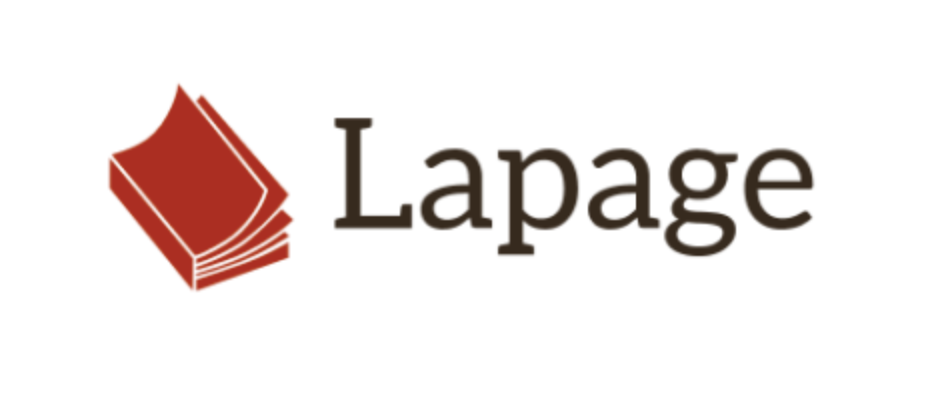

# Analyser les ventes d'une librairie

# Table des matières

* [1 - Importation des libriairies et des modules](#chap1)
* [2 - Importation des documents](#chap2)
* [3 - Nettoyage des documents](#chap3)
    * [3.1 - Fichier "customers"](#chap3.1)
    * [3.2 - Fichier "products"](#chap3.2)
    * [3.3 - Fichier "transactions"](#chap3.3)
* [4 - Analyses préliminaires des documents](#chap4)
    * [4.1 - Fichier "customers"](#chap4.1)
    * [4.2 - Fichier "products"](#chap4.2)
        * [Valeurs extrêmes](#chap4.2.1)
            * [Méthode "métier"](#chap4.2.1.1)
            * [Méthode statistique interquartile](#chap4.2.1.2)
        * [Analyse du prix des livres par catégories](#chap4.2.2)
    * [4.3 - Fichier "transactions"](#chap4.3)
* [5 - Jointure des fichiers](#chap5)
* [6 - Etude du chiffre d'affaires et des indicateurs de ventes ](#chap6)
    * [6.1 - Chiffre d'affaires](#chap6.1)
        * [Total](#chap6.1.1)
        * [Par an](#chap6.1.2)
        * [Par mois](#chap6.1.3)
        * [Par jour](#chap6.1.4)
    * [6.2 - TOP](#chap6.2)
    * [6.3 - FLOP](#chap6.3)
    * [6.4 - Catégories](#chap6.4)
    * [6.5 - Autres chiffres clés](#chap6.5)
        * [Courbe de Lorenz sur la répartition du CA entre les produits](#chap6.5.1)
        * [Recherche des meilleurs clients](#chap6.5.2)
        * [Achat et montant moyen par client](#chap6.5.3)
        * [Courbe de Lorenz sur la répartition du CA entre les clients](#chap6.5.4)
        * [Nombre moyen d'achats par sessions](#chap6.5.5)
        * [Répartition du genre parmi les clients](#chap6.5.6)
        * [Dépenses par genre](#chap6.5.7)
* [7 - Corrélations :](#chap7)
    * [7.1 - Entre le genre et la catégorie d'achat](#chap7.1)
    * [7.2 - Entre l'âge et le montant](#chap7.2)
    * [7.3 - Entre l'âge et les catégories](#chap7.3)
    * [7.4 - Entre l'âge et la fréquence d'achat](#chap7.4)
    * [7.5 - Entre l'âge et le panier moyen](#chap7.5)
        

## 1 - Importation des librairies et modules  <a class="anchor" id="chap1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import collections
import datetime as dt
import scipy.stats as st
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols

## 2 - Importation des documents <a class="anchor" id="chap2"></a>

In [2]:
customers = pd.read_csv('customers.csv', sep=';')
products = pd.read_csv('products.csv', sep=';')
transactions = pd.read_csv('Transactions.csv',sep=';')

## 3 - Nettoyage des documents <a class="anchor" id="chap3"></a>

### 3.1 - Fichier "customers" <a class="anchor" id="chap3.1"></a>

In [3]:
#Vue globale : 
customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8616,c_7920,m,1956
8617,c_7403,f,1970
8618,c_5119,m,1974
8619,c_5643,f,1968


In [4]:
#Vérification du typage des données :
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [5]:
#Contenu de la table : 
customers.describe()

,birth
count,8621.000000
mean,1978.275606
std,16.917958
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [6]:
#Vérification de la présence de doublons : 
doublons_cust = customers.duplicated().sum()
print(f"Il y a {doublons_cust} doublon dans le fichier customers")

Il y a 0 doublon dans le fichier customers


In [7]:
#Création de la colonne âge : 
annee_actuelle = datetime.now().strftime('%Y')

customers["age"] = int(annee_actuelle) - customers["birth"]

customers.head()

,client_id,sex,birth,age
0,c_4410,f,1967,57
1,c_7839,f,1975,49
2,c_1699,f,1984,40
3,c_5961,f,1962,62
4,c_5320,m,1943,81


L'ajout de la colonne "age" semble pertinent pour l'exercice et facilitera les calculs ultérieurs

<b>Le fichier "customers" est considéré comme propre et utilisable pour l'exercice.</b>

### 3.2 - Fichier "products"<a class="anchor" id="chap3.2"></a>

In [8]:
#Vue globale : 
products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3281,2_23,115.99,2
3282,0_146,17.14,0
3283,0_802,11.22,0
3284,1_140,38.56,1


In [9]:
#Vérification du typage des données :
products.info()

#Passage de "categ"int64 en object
products["categ"] = products["categ"].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.1+ KB


In [10]:
#Contenu de la table :
products.describe()

,price
count,3286.000000
mean,21.863597
std,29.849786
min,0.620000
25%,6.990000
50%,13.075000
75%,22.990000
max,300.000000


In [11]:
#Vérification de la présence de doublons : 
doublons_prod = products.duplicated().sum()
print(f"Il y a {doublons_prod} doublon dans le fichier products")

Il y a 0 doublon dans le fichier products


La table products contient une colonne catégorie qui est en fait identique au premier caractère de l’identifiant du produit.<br>
On la conserve pour notre analyse, car cela n'impacte pas les résultats, mais dans l'idéal, il faudrait la transformer pour arriver à une forme 1NF (forme anatomique et non dupliquée). L'ISBN étant déjà un identifiant unique du livre, il serait intéressant de faire le rapprochement avec le "prod_id".

<b>Le fichier "products" est considéré comme propre et utilisable pour l'exercice.</b>

### 3.3 - Fichier "transactions" <a class="anchor" id="chap3.3"></a>

In [12]:
#Vue globale :
transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848


In [13]:
#Vérification du typage des données :
transactions.info()
#Passage de "date" en datetime avec retrait des heures (inutiles à l'exercice)
transactions["date"] = transactions["date"].str.split(" ", expand = True)[0]
transactions["date"] = pd.to_datetime(transactions["date"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687534 entries, 0 to 687533
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     687534 non-null  object
 1   date        687534 non-null  object
 2   session_id  687534 non-null  object
 3   client_id   687534 non-null  object
dtypes: object(4)
memory usage: 21.0+ MB


In [14]:
#Contenu de la table :
transactions.describe()

,date
count,687534
mean,2022-03-01 09:22:26.987930880
min,2021-03-01 00:00:00
25%,2021-09-10 00:00:00
50%,2022-02-27 00:00:00
75%,2022-08-28 00:00:00
max,2023-02-28 00:00:00


In [15]:
#Vérification de la présence de doublons : 
doublons_transac = transactions.duplicated().sum()
print(f"Il y a {doublons_transac} doublons dans le fichier transactions")

Il y a 848 doublons dans le fichier transactions


In [16]:
#Vue sur les doublons : 
transac_dup = transactions[transactions[['id_prod', 'date', 'session_id', 'client_id']].duplicated() == True]
transac_dup

,id_prod,date,session_id,client_id
999,1_483,2021-03-02,s_504,c_3678
1264,0_1453,2021-03-02,s_634,c_5603
2379,0_1158,2021-03-03,s_1172,c_7732
2547,1_498,2021-03-03,s_1255,c_6714
3068,0_1442,2021-03-04,s_1489,c_1918
...,...,...,...,...
686460,2_208,2023-02-27,s_347896,c_4958
686618,1_444,2023-02-28,s_347964,c_5185
686626,1_417,2023-02-28,s_347985,c_6057
687165,1_448,2023-02-28,s_348256,c_3366


In [17]:
#Exemple de doublon :
transactions.loc[(transactions["client_id"]=="c_3678")&(transactions["session_id"]=="s_504")]

,id_prod,date,session_id,client_id
988,1_483,2021-03-02,s_504,c_3678
999,1_483,2021-03-02,s_504,c_3678


Aucune autre information n'étant disponible et aucun individu ne sortant particulièrement du lot, on ne peut pas savoir si il s'agit d'un doublon ou d'un client qui aurait acheté 2 fois le même produit. En considérant la deuxième option comme vraie, on ne peut pas supprimer ces données.

<b>Le fichier "transaction" est considéré comme propre et utilisable pour l'exercice.</b>

## 4 - Analyses préliminaires des documents <a class="anchor" id="chap4"></a>

### 4.1 - Fichier "customers" <a class="anchor" id="chap4.1"></a>

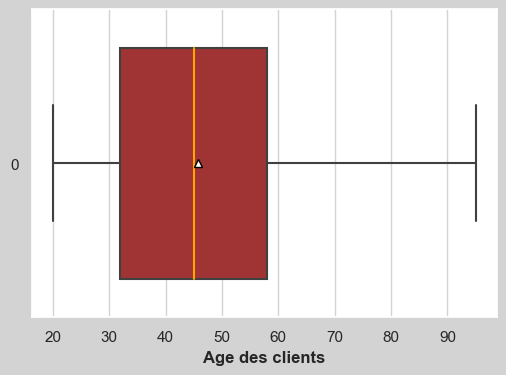

In [18]:
# analyse de l'age des clients avec boxplot
sns.set(rc={'figure.figsize':(6,4),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph1 = sns.boxplot(data=customers['age'],orient="h", width=0.75,
                    flierprops={"marker": "1"}, medianprops={"color" : "orange"}, 
                     meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, 
                     showmeans=True, color="firebrick")
plt.xticks()
plt.xlabel('Age des clients', fontweight='bold')
plt.grid(axis='x', color='lightgrey')
plt.savefig("graph1.png", bbox_inches='tight')

-Client le plus jeune : 20 ans <br>
-Client le plus âgé : 95 ans <br>
-Moyenne : 45 ans <br>
-Concentration entre 32 et 58 ans

In [19]:
# Nombre de client_id dans la table customers
clients_cust = len(customers['client_id'].unique())
print(clients_cust, "identifiants clients sont présents dans le fichier clients.")

8621 identifiants clients sont présents dans le fichier clients.


### 4.2 - Fichier "products" <a class="anchor" id="chap4.2"></a>

In [20]:
# Nombre de id_prod présents dans products : 
ref = len(products['id_prod'].unique())
print(ref, "identifiants produit sont présents dans le fichier products.")

3286 identifiants produit sont présents dans le fichier products.


#### Valeurs extrêmes : <a class="anchor" id="chap4.2.1"></a>

##### Méthode "métier" <a class="anchor" id="chap4.2.1.1"></a>

In [21]:
#Prix mini :
price_mini = products.loc[products["price"]<=1]
price_mini.count()

id_prod    29
price      29
categ      29
dtype: int64

In [22]:
#Liste prix mini : 
price_mini

,id_prod,price,categ
145,0_1203,0.99,0
370,0_120,0.66,0
686,0_2138,0.93,0
800,0_2166,0.97,0
847,0_180,0.97,0
945,0_2169,0.99,0
984,0_2275,0.99,0
990,0_1329,0.99,0
1210,0_1844,0.77,0
1529,0_1620,0.80,0


In [23]:
#prix_maxi :
price_maxi = products.loc[products["price"]>=150]
price_maxi.count()

id_prod    44
price      44
categ      44
dtype: int64

In [24]:
#Liste prix maxi :
price_maxi

,id_prod,price,categ
10,2_228,225.17,2
73,2_225,157.99,2
79,2_187,157.99,2
95,2_128,201.74,2
104,2_151,156.99,2
107,2_103,157.99,2
117,2_172,158.17,2
214,2_78,167.49,2
297,2_144,157.42,2
394,2_158,247.22,2


Avec la méthode dite 'métier', il y a 29 valeurs atypiques en-dessous de la normale et 44 au-dessus.

Tous les articles à bas prix sont issus de la catégorie 0, alors que les prix élevés sont de la catégorie 2.
Il sera utile de regarder plus en avant la répartition des produits suivant les catégories.

##### Méthode statistique interquartile <a class="anchor" id="chap4.2.1.2"></a>

In [25]:
#Calcul des quartiles 1 et 3 : 
Q1 = np.percentile(products['price'], 25)
print("Quartile Q1 vaut : ", Q1)
Q3 = np.percentile(products["price"], 75)
print("Quartile Q3 vaut : ", Q3)

#Calcul interval interquartile : 
interval_IQ = round(Q3-Q1,2)
print("L'interval interquartile est de :", interval_IQ)

#Calcul des valeurs atypiques : 
valeurs_atyp_mini = round(Q1-(1.5*interval_IQ),2)
print("Valeur atypique mini :" ,valeurs_atyp_mini)
valeurs_atyp_maxi = round(Q3+(1.5*interval_IQ),2)
print("Valeur atypique maxi :",valeurs_atyp_maxi)

Quartile Q1 vaut :  6.99
Quartile Q3 vaut :  22.99
L'interval interquartile est de : 16.0
Valeur atypique mini : -17.01
Valeur atypique maxi : 46.99


In [26]:
valeur_atypique_mini = products.loc[products["price"]<=valeurs_atyp_mini]
valeur_atypique_mini

,id_prod,price,categ


In [27]:
valeur_atypique_maxi = products.loc[products["price"]>=valeurs_atyp_maxi]
valeur_atypique_maxi.count()

id_prod    302
price      302
categ      302
dtype: int64

In [28]:
#Liste des valeurs atypiques maxi : 
valeur_atypique_maxi

,id_prod,price,categ
10,2_228,225.17,2
11,1_178,51.92,1
38,2_100,72.11,2
49,1_48,47.22,1
64,2_89,107.99,2
...,...,...,...
3266,2_101,63.99,2
3268,1_543,51.99,1
3270,2_123,147.99,2
3278,1_331,55.99,1


La méthode interquartile ne fait ressortir aucune valeur atypique en mini, mais 302 individus en maxi, répartis cette fois-ci sur les catégories 1 et 2.

##### Analyse du prix des livres par catégorie <a class="anchor" id="chap4.2.2"></a>

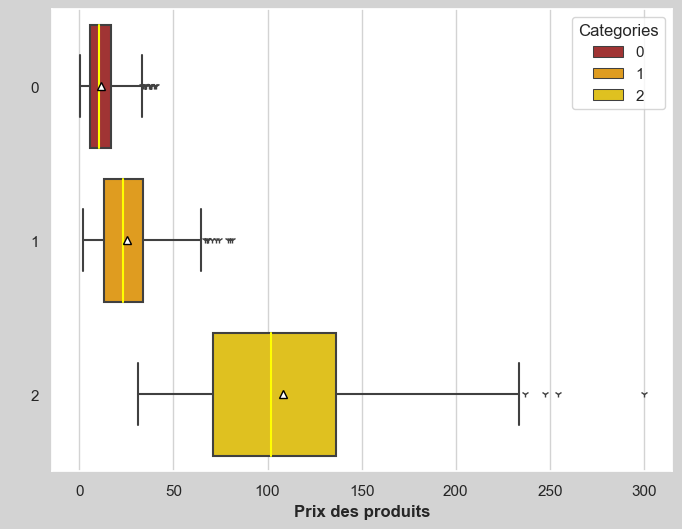

In [29]:
sns.set(rc={'figure.figsize':(8,6),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph2 = sns.boxplot(data=products, y="categ", x="price", hue="categ", 
                     orient="h", dodge=False, flierprops={"marker": "1"},
                     medianprops={"color" : "yellow"}, meanprops={"markerfacecolor":"white", 
                     "markeredgecolor":"black"}, palette=["firebrick", 'orange', 'gold'], 
                     showmeans=True)
plt.xlabel('Prix des produits', fontweight='bold')
plt.ylabel(' ')
plt.legend(title="Categories")
plt.grid(axis='x', color='lightgrey')
plt.savefig("graph2.png", bbox_inches='tight')
plt.show()

In [30]:
#Calcul des valeurs atypiques pour la catégorie 0:
categ_0 = products.loc[products["categ"] == "0"].reset_index(drop=True)

Q1_categ_0 = np.percentile(categ_0["price"], 25)
Q3_categ_0 = np.percentile(categ_0['price'], 75)

# écart interquartile
categ_0_IQ = Q3_categ_0 - Q1_categ_0

# Valeurs atypiques : 
categ_0_va = Q3_categ_0 + categ_0_IQ*1.5
print("Valeur de la moustache haute pour la categorie 0:", round(categ_0_va, 2), "€")

# Liste :
categ_0_outliers = categ_0[categ_0["price"] > categ_0_va]
print(categ_0_outliers.shape[0], "articles de categorie 0 ont un prix supérieur à la moustache haute dans la table products. Liste:")
categ_0_outliers

Valeur de la moustache haute pour la categorie 0: 33.26 €
22 articles de categorie 0 ont un prix supérieur à la moustache haute dans la table products. Liste:


,id_prod,price,categ
5,0_2157,34.99,0
30,0_1629,40.99,0
52,0_548,37.53,0
125,0_1016,35.06,0
259,0_907,34.99,0
264,0_1239,37.99,0
350,0_822,35.30,0
389,0_197,37.99,0
423,0_289,36.99,0
855,0_1544,37.91,0


In [31]:
#Calcul des valeurs atypiques pour la catégorie 1 :
categ_1 = products.loc[products["categ"] == "1"].reset_index(drop=True)

Q1_categ_1 = np.percentile(categ_1["price"], 25)
Q3_categ_1 = np.percentile(categ_1['price'], 75)

# écart interquartile
categ_1_IQ = Q3_categ_1 - Q1_categ_1

# Valeurs atypiques : 
categ_1_va = Q3_categ_1 + categ_1_IQ*1.5
print("Valeur de la moustache haute pour la categorie 1:", round(categ_1_va, 2), "€")

# Liste :
categ_1_outliers = categ_1[categ_1["price"] > categ_1_va]
print(categ_1_outliers.shape[0], "articles de categorie 1 ont un prix supérieur à la moustache haute dans la table products. Liste:")
categ_1_outliers

Valeur de la moustache haute pour la categorie 1: 64.89 €
10 articles de categorie 1 ont un prix supérieur à la moustache haute dans la table products. Liste:


,id_prod,price,categ
48,1_496,70.51,1
178,1_315,66.99,1
192,1_10,78.83,1
195,1_13,80.99,1
209,1_679,79.99,1
243,1_354,68.49,1
375,1_184,67.65,1
515,1_514,67.66,1
622,1_171,73.99,1
661,1_608,72.75,1


In [32]:
#Calcul des valeurs atypiques pour la catégorie 2 :
categ_2 = products.loc[products["categ"] == "2"].reset_index(drop=True)

Q1_categ_2 = np.percentile(categ_2["price"], 25)
Q3_categ_2 = np.percentile(categ_2['price'], 75)

# écart interquartile
categ_2_IQ = Q3_categ_2 - Q1_categ_2

# Valeurs atypiques : 
categ_2_va = Q3_categ_2 + categ_2_IQ*1.5
print("Valeur de la moustache haute pour la categorie 2:", round(categ_2_va, 2), "€")

# Liste :
categ_2_outliers = categ_2[categ_2["price"] > categ_2_va]
print(categ_2_outliers.shape[0], "articles de categorie 2 ont un prix supérieur à la moustache haute dans la table products. Liste:")
categ_2_outliers

Valeur de la moustache haute pour la categorie 2: 234.73 €
4 articles de categorie 2 ont un prix supérieur à la moustache haute dans la table products. Liste:


,id_prod,price,categ
30,2_158,247.22,2
52,2_76,254.44,2
70,2_2,300.00,2
102,2_167,236.99,2


Les informations ne permettent pas de discréminer les valeurs atypiques. Elles seront conservées pour le reste de l'analyse.

### 4.3 - Fichier "transactions" <a class="anchor" id="chap4.3"></a>

In [33]:
# Nombre de client unique dans la table transactions
clients_transac = len(transactions["client_id"].unique())
print(clients_transac, "identifiants clients sont présents dans le fichier transactions.")

8600 identifiants clients sont présents dans le fichier transactions.


In [34]:
# Calcul nombre clients n'ayant jamais acheté en ligne :
print((clients_cust - clients_transac), "clients n'ont jamais realisé d'achat en ligne :")

# Info sur ces clients : 
list_id = customers.loc[customers['client_id'].isin(transactions["client_id"]) == False]
list_id

21 clients n'ont jamais realisé d'achat en ligne :


,client_id,sex,birth,age
801,c_8253,f,2001,23
2483,c_3789,f,1997,27
2734,c_4406,f,1998,26
2768,c_2706,f,1967,57
2850,c_3443,m,1959,65
3178,c_4447,m,1956,68
3189,c_3017,f,1992,32
3333,c_4086,f,1992,32
3720,c_6930,m,2004,20
3820,c_4358,m,1999,25


In [35]:
# Nombre de références id_prod présentent dans transactions
refvendues = len(transactions['id_prod'].unique())
print(refvendues, "identifiants produit sont présents dans le fichier transactions.")

# Nombre de livres jamais vendus : 
non_ventes = len(products.loc[products["id_prod"].isin(transactions["id_prod"]) == False])
print(non_ventes, "livres n'ont jamais été vendus")

# Recherche de références non vendues : 
non_vendus = products.loc[products["id_prod"].isin(transactions["id_prod"]) == False]     
print("Liste des livres jamais vendus en ligne:")      
non_vendus

3265 identifiants produit sont présents dans le fichier transactions.
21 livres n'ont jamais été vendus
Liste des livres jamais vendus en ligne:


,id_prod,price,categ
184,0_1016,35.06,0
279,0_1780,1.67,0
736,0_1062,20.08,0
793,0_1119,2.99,0
810,0_1014,1.15,0
845,1_0,31.82,1
1030,0_1318,20.92,0
1138,0_1800,22.05,0
1346,0_1645,2.99,0
1504,0_322,2.99,0


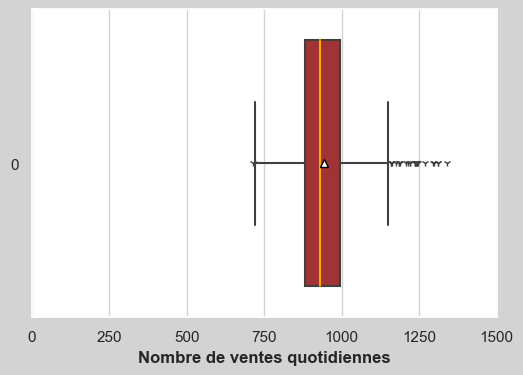

In [36]:
#Création d'un dataframe pour les graphiques : 
df_transac_graph = transactions.groupby('date')[['session_id', 'id_prod']].agg(['count', 'size', 'nunique']).reset_index()

#Box plot des ventes par jour :
sns.set(rc={'figure.figsize':(6,4),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph3 = sns.boxplot(data=df_transac_graph[('id_prod', 'count')], orient="h",
                     flierprops={"marker": "1"},medianprops={"color" : "orange"}, 
                     meanprops={"markerfacecolor":"white", "markeredgecolor":"black"}, 
                     showmeans=True, color = "firebrick")
plt.xticks([0, 250, 500, 750, 1000,1250,1500])
plt.xlabel('Nombre de ventes quotidiennes', fontweight='bold')
plt.grid(axis='x', color='lightgrey')
plt.savefig("graph3.png", bbox_inches='tight')

In [37]:
# Test Shapiro-Wilk pour les ventes journalières
stat, p = st.shapiro(df_transac_graph[('id_prod', 'count')])
alpha = 0.05
print('Statistique de test:', round(stat,4))
print('p-value:', round(p,4))
if p > alpha:
    print('La distribution est probablement gaussienne.')
else:
    print("La distribution n'est probablement pas gaussienne.")

Statistique de test: 0.9672
p-value: 0.0
La distribution n'est probablement pas gaussienne.


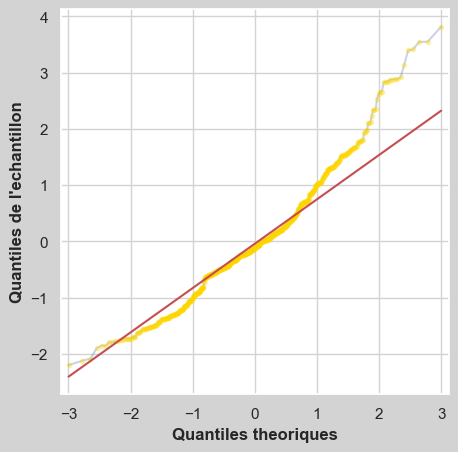

In [38]:
# Vérification de la Loi Normale pour les ventes journalières avec QQPlot : 
sns.set(rc={'figure.figsize':(5, 5),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph4 = sm.qqplot(df_transac_graph[('id_prod', 'count')],marker='.', alpha=0.3, 
                   markerfacecolor='gold', markeredgecolor='gold', linestyle='solid', 
                   line="q", fit=True)
plt.xlabel("Quantiles theoriques", fontweight='bold')
plt.ylabel("Quantiles de l'echantillon", fontweight='bold')
plt.grid(axis='both', color='lightgrey')
plt.savefig("graph4.png", bbox_inches='tight')

Les quantiles de l'echantillon s'ecartent de manière significative des quantiles théoriques d'une loi Normale. Les résultats numériques sont donc confirmés.

### L'ensemble des données est conservé pour la jointure des fichiers

## 5 - Jointure des fichiers <a class="anchor" id="chap5"></a>

In [39]:
customers_transactions = customers.merge(transactions, on='client_id', how='outer')

In [40]:
df_complet = customers_transactions.merge(products, on='id_prod', how='outer')

In [41]:
df_complet

,client_id,sex,birth,age,id_prod,date,session_id,price,categ
0,c_4410,f,1967.0,57.0,1_483,2021-03-13,s_5913,15.99,1
1,c_4410,f,1967.0,57.0,1_483,2022-03-13,s_178686,15.99,1
2,c_4410,f,1967.0,57.0,1_483,2022-05-13,s_208054,15.99,1
3,c_6446,m,1971.0,53.0,1_483,2021-10-21,s_109855,15.99,1
4,c_7049,f,1987.0,37.0,1_483,2021-10-02,s_100270,15.99,1
...,...,...,...,...,...,...,...,...,...
687571,NaN,NaN,NaN,NaN,0_1624,NaT,NaN,24.50,0
687572,NaN,NaN,NaN,NaN,2_86,NaT,NaN,132.36,2
687573,NaN,NaN,NaN,NaN,0_299,NaT,NaN,22.99,0
687574,NaN,NaN,NaN,NaN,0_510,NaT,NaN,23.66,0


In [42]:
#Pour faciliter les calculs par la suite on créer une table qui ne contient que les ventes 
#(donc pas les clients non acheteurs ou les produits non vendus qui pourront être analysés à part)

# Creation de df_ventes:
df_ventes = df_complet.dropna()
df_ventes.info()

# Pour faciliter la manipulation des dates:
df_ventes["year"] = df_ventes["date"].dt.year
df_ventes["month"] = df_ventes["date"].dt.month
df_ventes["day"] = df_ventes["date"].dt.day

<class 'pandas.core.frame.DataFrame'>
Index: 687534 entries, 0 to 687554
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   687534 non-null  object        
 1   sex         687534 non-null  object        
 2   birth       687534 non-null  float64       
 3   age         687534 non-null  float64       
 4   id_prod     687534 non-null  object        
 5   date        687534 non-null  datetime64[ns]
 6   session_id  687534 non-null  object        
 7   price       687534 non-null  float64       
 8   categ       687534 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 52.5+ MB


/var/folders/87/g06h6c1d3sngmfl_qg1wtysh0000gn/T/ipykernel_65224/196837822.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventes["year"] = df_ventes["date"].dt.year
/var/folders/87/g06h6c1d3sngmfl_qg1wtysh0000gn/T/ipykernel_65224/196837822.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventes["month"] = df_ventes["date"].dt.month
/var/folders/87/g06h6c1d3sngmfl_qg1wtysh0000gn/T/ipykernel_65224/196837822.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

## 6 - Etude du chiffre d'affaires et des indicateurs de ventes <a class="anchor" id="chap6"></a>

### 6.1 - Chiffre d'affaire <a class="anchor" id="chap6.1"></a>

##### Total <a class="anchor" id="chap6.1.1"></a>

In [43]:
# CA total:
ca_tot = round(df_complet.loc[(df_complet["client_id"] != "NaN"),"price"].sum(),2)
ventes_tot = df_ventes["session_id"].count()

print("Le chiffre d'affaires total est de", ca_tot, "€")
print("pour un total de", ventes_tot, "ventes.")

Le chiffre d'affaires total est de 12028458.38 €
pour un total de 687534 ventes.


##### Par an <a class="anchor" id="chap6.1.2"></a>

In [44]:
# CA par années:
ca_annuel = df_ventes.groupby(["year"])["price"].sum()
print("Chiffres d'affaires annuels:\n", ca_annuel)

# Ventes par années:
ventes_annuelles = df_ventes.groupby(["year"])["session_id"].count()
print("Nombre de ventes annuelles:\n", ventes_annuelles)

Chiffres d'affaires annuels:
 year
2021    4944760.98
2022    6108681.81
2023     974220.31
Name: price, dtype: float64
Nombre de ventes annuelles:
 year
2021    286671
2022    346380
2023     54483
Name: session_id, dtype: int64


La meilleure année semble être 2022, mais les chiffres ne sont pas complets pour 2023. Une analyse mensuelle permettrait de voir si les chiffres de 2023 peuvent être comparés à 2022 ou non.

##### Par mois <a class="anchor" id="chap6.1.3"></a>

In [45]:
# CA mensuel:
df_ventes = df_ventes.sort_values(["date"],ascending=True)
ca_mensu = df_ventes.groupby(["year","month"])["price"].sum()

# Nombre de ventes mensuelles:
ventes_mensu = df_ventes.groupby(["year", "month"])["session_id"].count()

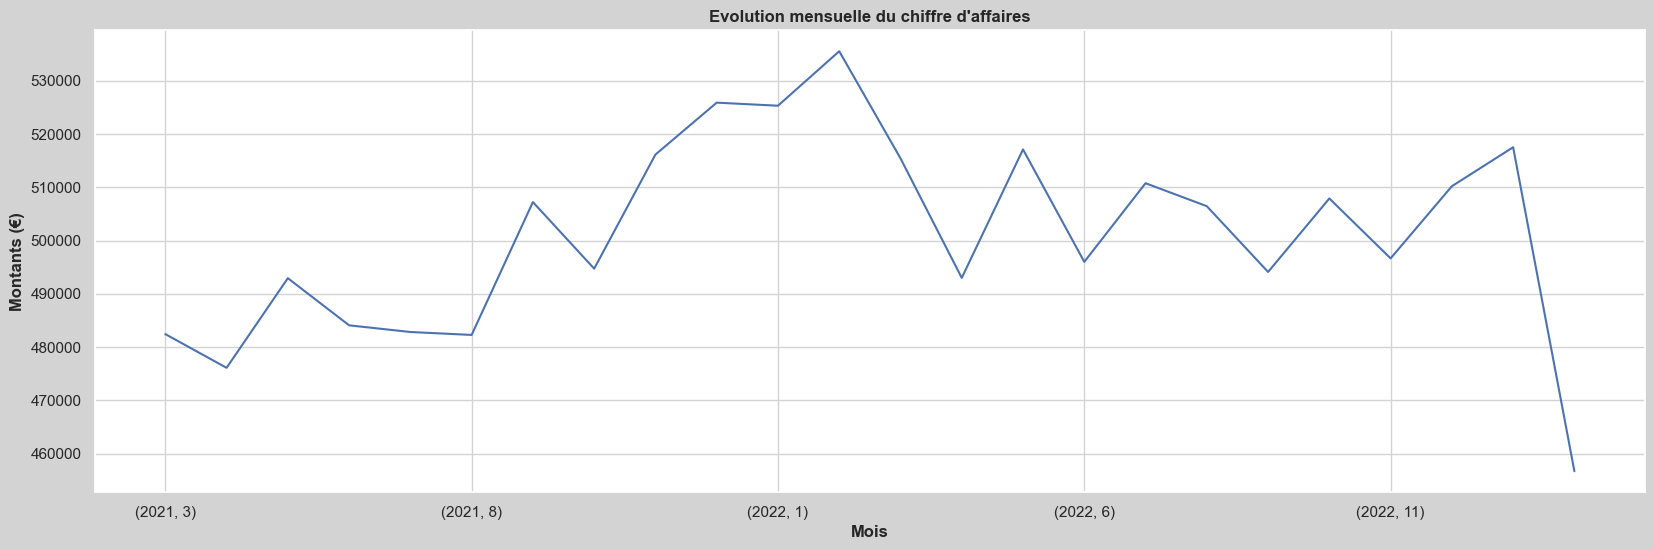

In [46]:
# Graphique CA par mois : 
sns.set(rc={'figure.figsize':(5, 5),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph5 = plt.figure(figsize = (20,6))
ca_mensu.plot()
plt.xlabel("Mois", fontweight='bold')
plt.ylabel("Montants (€)", fontweight='bold')
plt.grid(axis='both', color='lightgrey')
plt.title("Evolution mensuelle du chiffre d'affaires", fontweight='bold')
plt.savefig("graph5.png", bbox_inches='tight')


##### Par jour <a class="anchor" id="chap6.1.4"></a>

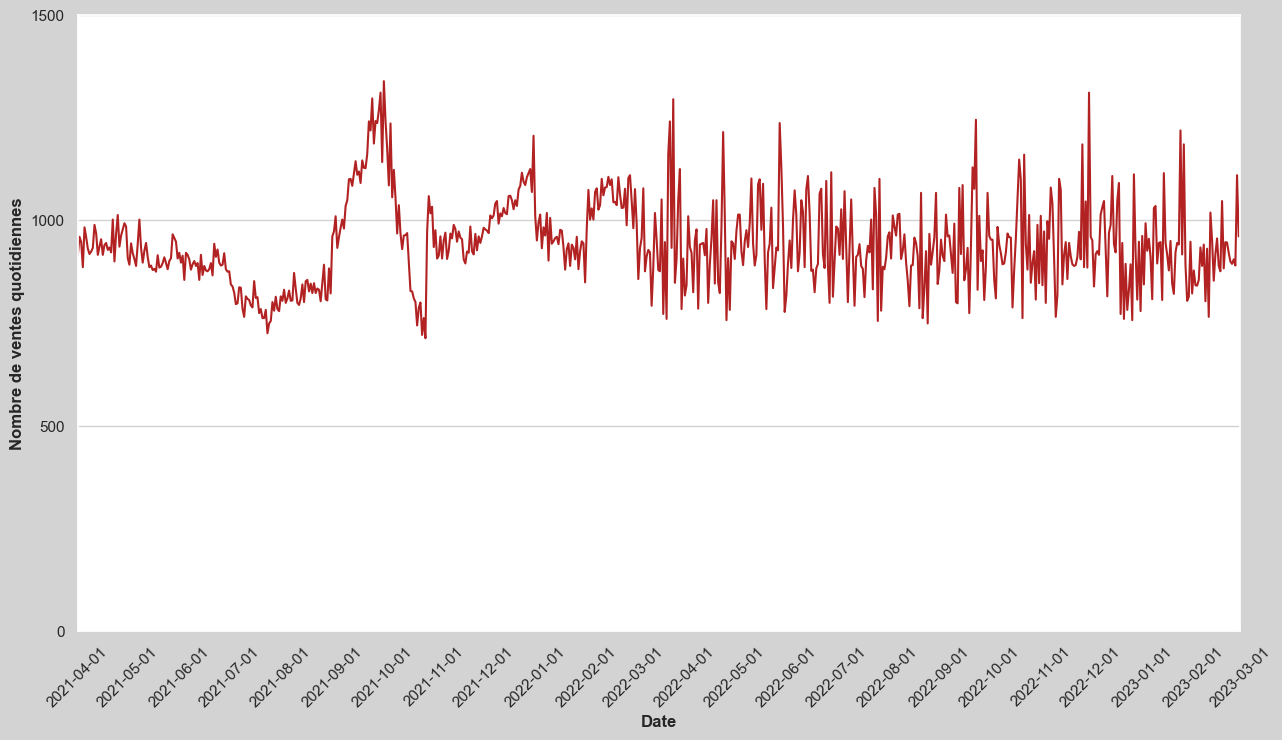

In [47]:
# graphique des ventes par jours :
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph6 = sns.lineplot(data=df_transac_graph, x=('date'), y=('id_prod', 'count'), color="firebrick")
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12','2023-01', '2023-02', '2023-03'], rotation=45)
plt.yticks([0,500,1000,1500])
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Nombre de ventes quotidiennes', fontweight='bold')
plt.grid(axis='y', color='lightgrey')
plt.savefig("graph6.png",bbox_inches='tight')

In [48]:
# CA journalier
ca_jour = df_ventes.groupby(['date'])['price'].sum().reset_index()
ca_jour.rename(columns={'price': 'ca_jour'}, inplace=True)

# Calcul moyenne mobile
ca_jour['SMA_weekly'] = ca_jour['ca_jour'].rolling(7, min_periods=1).mean()
ca_jour['SMA_monthly'] = ca_jour['ca_jour'].rolling(30, min_periods=1).mean()
ca_jour['SMA_quarterly'] = ca_jour['ca_jour'].rolling(90, min_periods=1).mean()
ca_jour['SMA_yearly'] = ca_jour['ca_jour'].rolling(360, min_periods=1).mean()

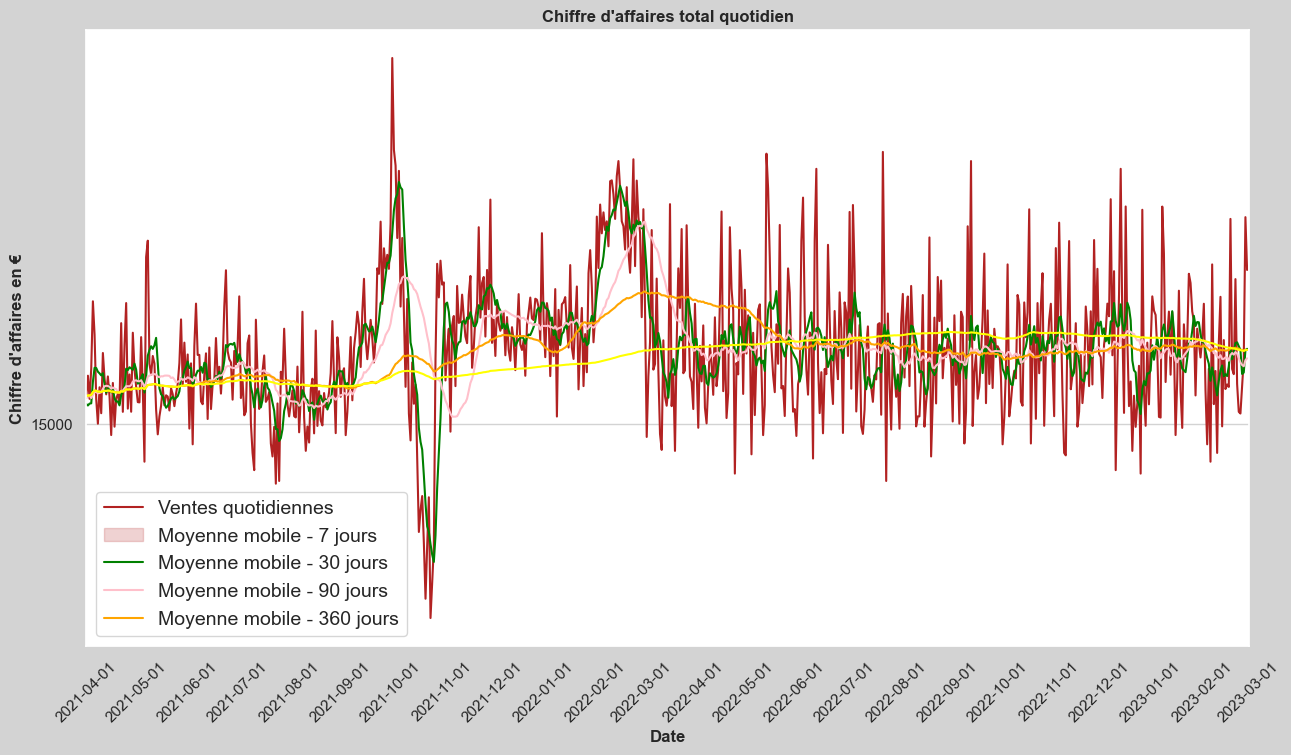

In [49]:
# CA jour avec moyenne mobile :
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph7 = sns.lineplot(data=ca_jour, x='date', y='ca_jour', color='firebrick')
graph7.set_title("Chiffre d'affaires total quotidien", fontweight = 'bold')
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
            '2023-01', '2023-02', '2023-03'], rotation=45)
plt.yticks([0,5000,10000,15000])
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.xlabel('Date',fontweight = 'bold')
plt.ylabel("Chiffre d'affaires en €",fontweight = 'bold')
plt.grid(axis='y', color='lightgrey')
plt.plot(ca_jour['date'],ca_jour['SMA_weekly'],color = 'green')
plt.plot(ca_jour['date'],ca_jour['SMA_monthly'],color = 'pink')
plt.plot(ca_jour['date'],ca_jour['SMA_quarterly'],color = 'orange')
plt.plot(ca_jour['date'],ca_jour['SMA_yearly'],color = 'yellow')
plt.legend(labels=['Ventes quotidiennes','Moyenne mobile - 7 jours', 'Moyenne mobile - 30 jours','Moyenne mobile - 90 jours',
                    'Moyenne mobile - 360 jours'], fontsize=14)
plt.savefig("graph7.png",bbox_inches='tight')

### 6.2 - TOP <a class="anchor" id="chap6.2"></a>

In [50]:
#Création d'un df pour le TOP des ventes : 
df_top = df_ventes.groupby(["id_prod", "categ"])["categ"].count().sort_values(ascending=False)
df_top

id_prod  categ
1_369    1        2340
1_417    1        2269
1_414    1        2246
1_498    1        2202
1_425    1        2163
                  ... 
0_549    0           1
0_886    0           1
0_1498   0           1
0_541    0           1
0_1284   0           1
Name: categ, Length: 3265, dtype: int64

In [51]:
# Top 10 : 
df_top.head(10)

id_prod  categ
1_369    1        2340
1_417    1        2269
1_414    1        2246
1_498    1        2202
1_425    1        2163
1_403    1        2040
1_413    1        2036
1_412    1        2014
1_406    1        2003
1_407    1        2001
Name: categ, dtype: int64

In [52]:
df_top = pd.DataFrame(df_top)
df_top = df_top.rename(columns ={"categ" : "count"})

In [53]:
df_top = df_top.reset_index()
df_top

,id_prod,categ,count
0,1_369,1,2340
1,1_417,1,2269
2,1_414,1,2246
3,1_498,1,2202
4,1_425,1,2163
...,...,...,...
3260,0_549,0,1
3261,0_886,0,1
3262,0_1498,0,1
3263,0_541,0,1


### 6.3 - FLOP <a class="anchor" id="chap6.3"></a>

In [54]:
df_flop = df_ventes.loc[df_ventes["client_id"].isnull()]
df_flop

,client_id,sex,birth,age,id_prod,date,session_id,price,categ,year,month,day


In [55]:
print("Nous avons vu que 21 produits de la catégorie 0 n'ont jamais été vendu." 
      " Ce sont, par conséquent, les flop des ventes.")

Nous avons vu que 21 produits de la catégorie 0 n'ont jamais été vendu. Ce sont, par conséquent, les flop des ventes.


### 6.4 - Catégories <a class="anchor" id="chap6.4"></a>

In [56]:
#Répartition des livres par catégories : 
df_categ = collections.Counter(df_ventes["categ"])
df_categ

Counter({'0': 415459, '1': 235592, '2': 36483})

In [57]:
# CA par categories:
ca_categ = df_ventes.groupby(df_ventes["categ"])["price"].sum()
ca_categ = pd.DataFrame(ca_categ)
ca_categ.reset_index(inplace=True)

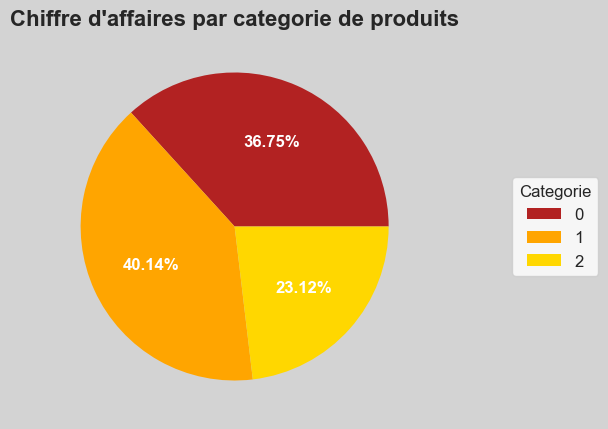

In [58]:
#Pie plot pour la répartition du CA : 
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_facecolor('lightgrey')
graph9 = plt.pie(ca_categ["price"], autopct='%1.2f%%', pctdistance=0.6, radius=1,
                   colors=("firebrick", 'orange', 'gold'), textprops={'fontsize': 12, 
                   'color':'white', 'fontweight':'bold'},
                   wedgeprops={'alpha':1, 'linewidth': 0})
ax.legend(ca_categ["categ"], title="Categorie", loc="center left", 
          bbox_to_anchor=(1.2, 0, 0.5, 1),
          fontsize=12)
ax.set_title("Chiffre d'affaires par categorie de produits", loc="center", 
            fontsize=16, fontweight='bold')
plt.savefig("graph9.png", bbox_inches='tight')

In [59]:
# Creation d'un df par catégories avec fonction d'agregation:
df_mens_agg = df_ventes[["categ", "price", "year", "month"]]
df_mens_agg = pd.pivot_table(df_mens_agg, index=["year","month"], columns=["categ"], 
                             aggfunc=["sum", "count"]).reset_index()
df_mens_agg.columns = ["year", "month", "categ_0", "categ_1", "categ_2", "vol_categ_0", 
                       "vol_categ_1", "vol_categ_2"]

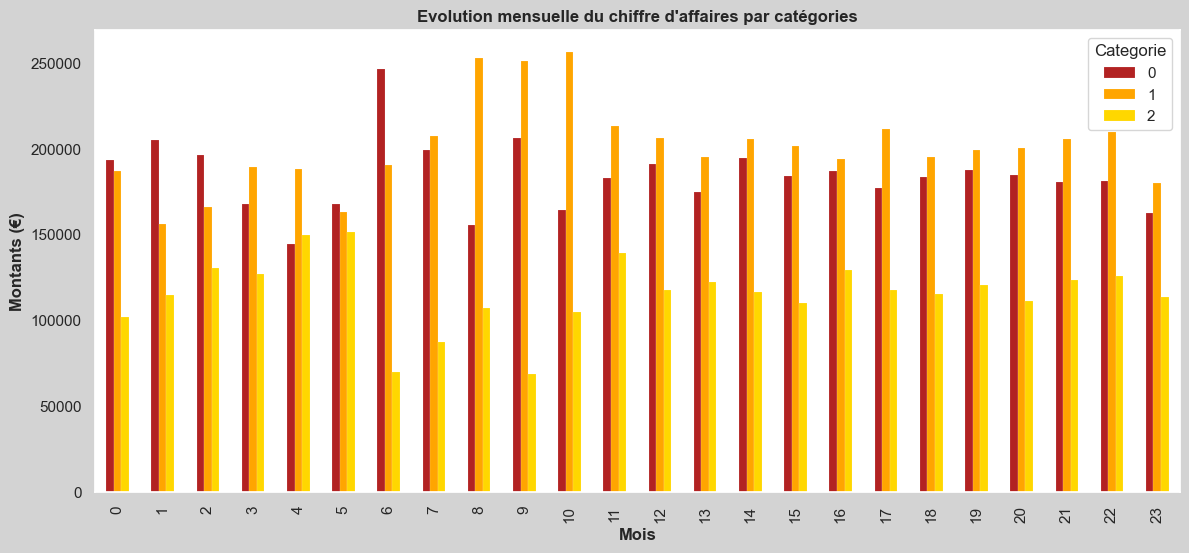

In [60]:
# Graphique CA par mois et par catégories :
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph10 = df_mens_agg[["categ_0", "categ_1", "categ_2"]].plot.bar(figsize=(14,6), 
                     linewidth = 0.1, color=("firebrick", 'orange', 'gold'))
plt.legend(ca_categ["categ"], title="Categorie", loc="upper right")
plt.xlabel("Mois", fontweight='bold')
plt.ylabel("Montants (€)", fontweight='bold')
plt.title("Evolution mensuelle du chiffre d'affaires par catégories", fontweight='bold')
plt.savefig("graph10png", bbox_inches='tight')

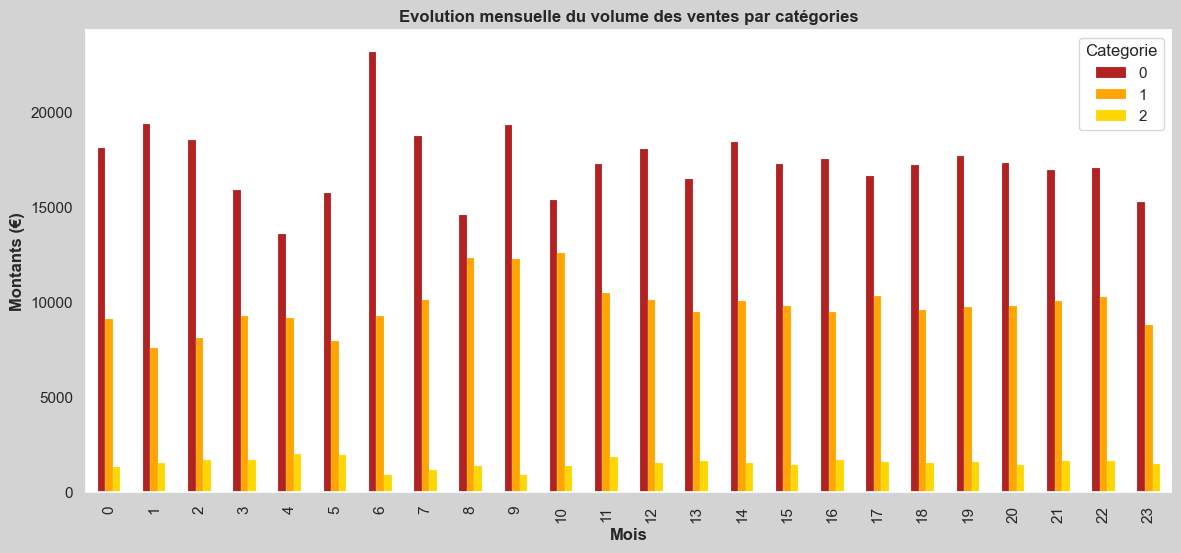

In [61]:
# Graphique volumde des ventes par mois et par catégories :
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph11 = df_mens_agg[["vol_categ_0", "vol_categ_1", "vol_categ_2"]].plot.bar(figsize=(14,6), 
                     linewidth = 0.1, color=("firebrick", 'orange', 'gold'))
plt.legend(ca_categ["categ"], title="Categorie", loc="upper right")
plt.xlabel("Mois", fontweight='bold')
plt.ylabel("Montants (€)", fontweight='bold')
plt.title("Evolution mensuelle du volume des ventes par catégories", fontweight='bold')
plt.savefig("graph11png", bbox_inches='tight')

In [62]:
#Création d'un nouveau df pour graphiques : 
df_ventes_graph = df_ventes.groupby(['date', 'categ'])['price'].sum().reset_index()
df_ventes_graph

,date,categ,price
0,2021-03-01,0,6262.65
1,2021-03-01,1,6811.53
2,2021-03-01,2,3491.04
3,2021-03-02,0,6718.27
4,2021-03-02,1,5627.15
...,...,...,...
2185,2023-02-27,1,6461.76
2186,2023-02-27,2,5271.62
2187,2023-02-28,0,4901.86
2188,2023-02-28,1,9226.25


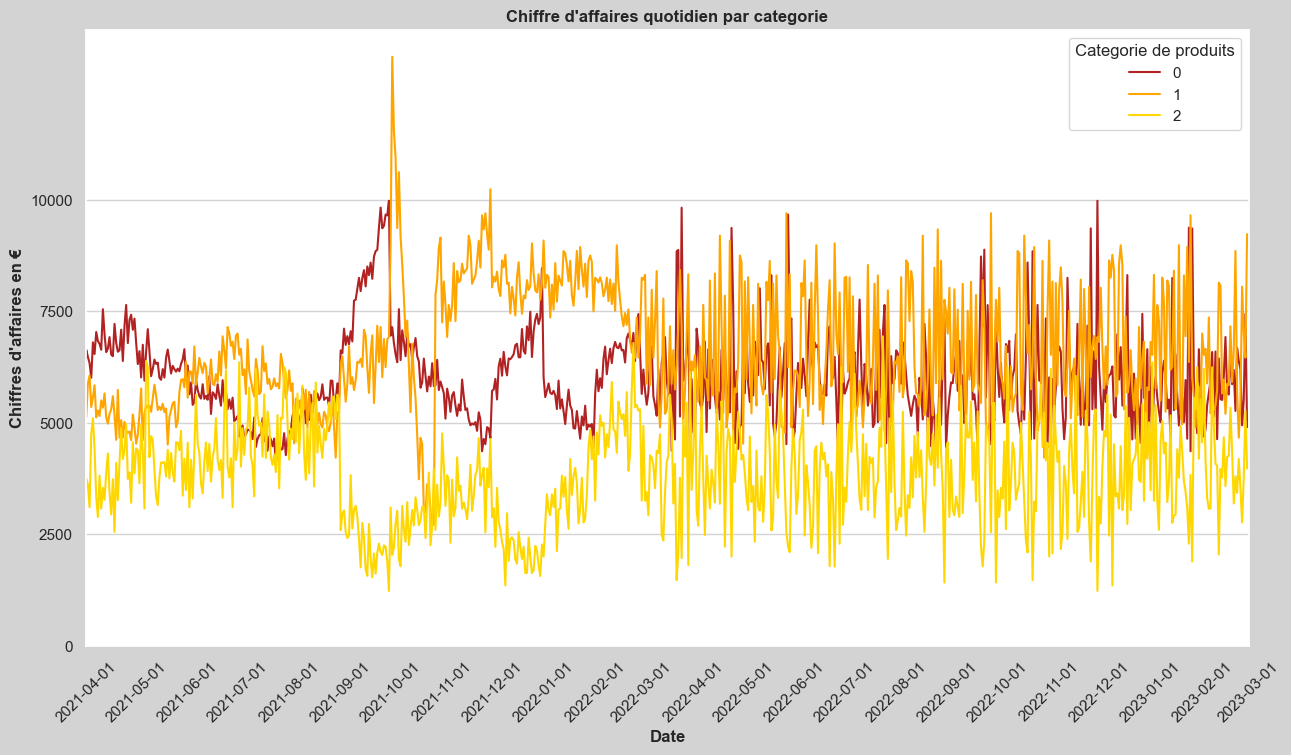

In [63]:
#Chiffre d'affaires quotidien par catégorie : 
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph12 = sns.lineplot(data=df_ventes_graph, x='date', y='price',hue='categ',
                      palette=['firebrick', 'orange', 'gold'])
graph12.set_title("Chiffre d'affaires quotidien par categorie", fontweight = 'bold')
plt.xlabel('Date',fontweight = 'bold')
sns.move_legend(graph12, "upper right", title='Categorie de produits')
plt.ylabel("Chiffres d'affaires en €",fontweight = 'bold')
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12', '2023-01', '2023-02', '2023-03'], rotation=45)
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.yticks([0,2500,5000,7500,10000])
plt.grid(axis='y', color = 'lightgrey')
plt.savefig("graph12.png", bbox_inches='tight')

##### Catégorie 0 <a class="anchor" id="chap6.4.1"></a>

In [64]:
# Création d'un DF pour la categ 0 et les moyennes mobiles : 
ca_jour_categ0 = df_ventes_graph.loc[df_ventes_graph['categ'] == '0'].copy()

ca_jour_categ0['SMA_weekly'] = ca_jour_categ0['price'].rolling(7, min_periods=1).mean()
ca_jour_categ0['SMA_monthly'] = ca_jour_categ0['price'].rolling(30, min_periods=1).mean()
ca_jour_categ0['SMA_quarterly'] = ca_jour_categ0['price'].rolling(90, min_periods=1).mean()
ca_jour_categ0['SMA_yearly'] = ca_jour_categ0['price'].rolling(360, min_periods=1).mean()

In [65]:
ca_jour_categ0

,date,categ,price,SMA_weekly,SMA_monthly,SMA_quarterly,SMA_yearly
0,2021-03-01,0,6262.65,6262.650000,6262.650000,6262.650000,6262.650000
3,2021-03-02,0,6718.27,6490.460000,6490.460000,6490.460000,6490.460000
6,2021-03-03,0,6121.03,6367.316667,6367.316667,6367.316667,6367.316667
9,2021-03-04,0,5891.48,6248.357500,6248.357500,6248.357500,6248.357500
12,2021-03-05,0,5975.97,6193.880000,6193.880000,6193.880000,6193.880000
...,...,...,...,...,...,...,...
2175,2023-02-24,0,6197.92,6172.365714,5910.832000,5870.327333,6002.364278
2178,2023-02-25,0,4942.69,5930.508571,5763.771333,5866.306778,5998.891611
2181,2023-02-26,0,5522.90,5881.618571,5749.772000,5854.285667,5998.346583
2184,2023-02-27,0,7437.43,6060.707143,5818.281667,5880.920556,6003.993611


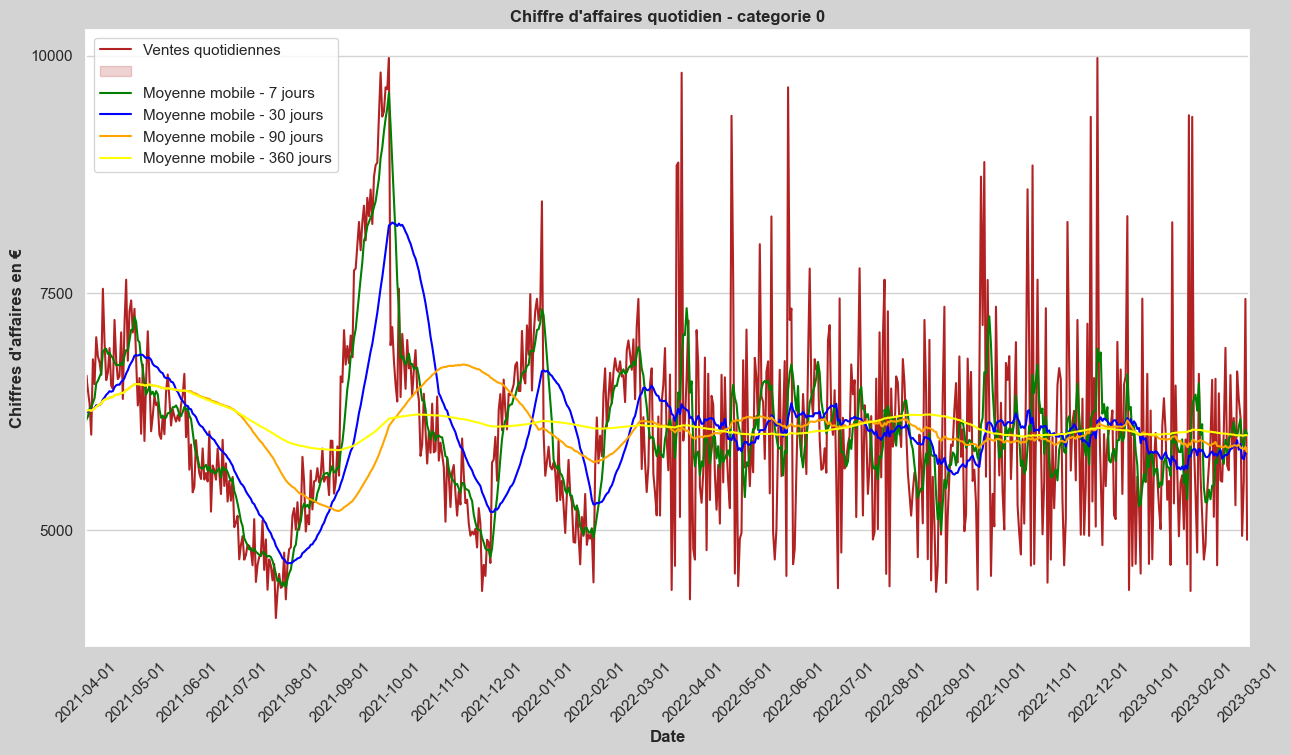

In [66]:
# graphique moyennes mobiles sur la categ 0 :
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph13 = sns.lineplot(data=ca_jour_categ0, x='date', y='price', color="firebrick")
graph13.set_title("Chiffre d'affaires quotidien - categorie 0",fontweight = 'bold')
plt.xlabel('Date',fontweight = 'bold')
plt.ylabel("Chiffres d'affaires en €",fontweight = 'bold')
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12', '2023-01', '2023-02', '2023-03'], rotation=45)
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.yticks([0,2500,5000,7500,10000])
plt.grid(axis = 'y', color="lightgrey")
plt.plot(ca_jour_categ0['date'],ca_jour_categ0['SMA_weekly'], color = 'green')
plt.plot(ca_jour_categ0['date'],ca_jour_categ0['SMA_monthly'], color = 'blue')
plt.plot(ca_jour_categ0['date'],ca_jour_categ0['SMA_quarterly'], color = 'orange')
plt.plot(ca_jour_categ0['date'],ca_jour_categ0['SMA_yearly'], color = 'yellow')
plt.legend(labels=['Ventes quotidiennes',"",'Moyenne mobile - 7 jours',
                    'Moyenne mobile - 30 jours','Moyenne mobile - 90 jours',
                    'Moyenne mobile - 360 jours'])
plt.savefig("graph13.png", bbox_inches='tight')
plt.show()

#####  Catégorie 1 <a class="anchor" id="chap6.4.2"></a>

In [67]:
# Création d'un DF pour la categ 1 et les moyennes mobiles
ca_jour_categ1 = df_ventes_graph.loc[df_ventes_graph['categ'] == '1'].copy()

ca_jour_categ1['SMA_weekly'] = ca_jour_categ1['price'].rolling(7, min_periods=1).mean()
ca_jour_categ1['SMA_monthly'] = ca_jour_categ1['price'].rolling(30, min_periods=1).mean()
ca_jour_categ1['SMA_quarterly'] = ca_jour_categ1['price'].rolling(90, min_periods=1).mean()
ca_jour_categ1['SMA_yearly'] = ca_jour_categ1['price'].rolling(360, min_periods=1).mean()

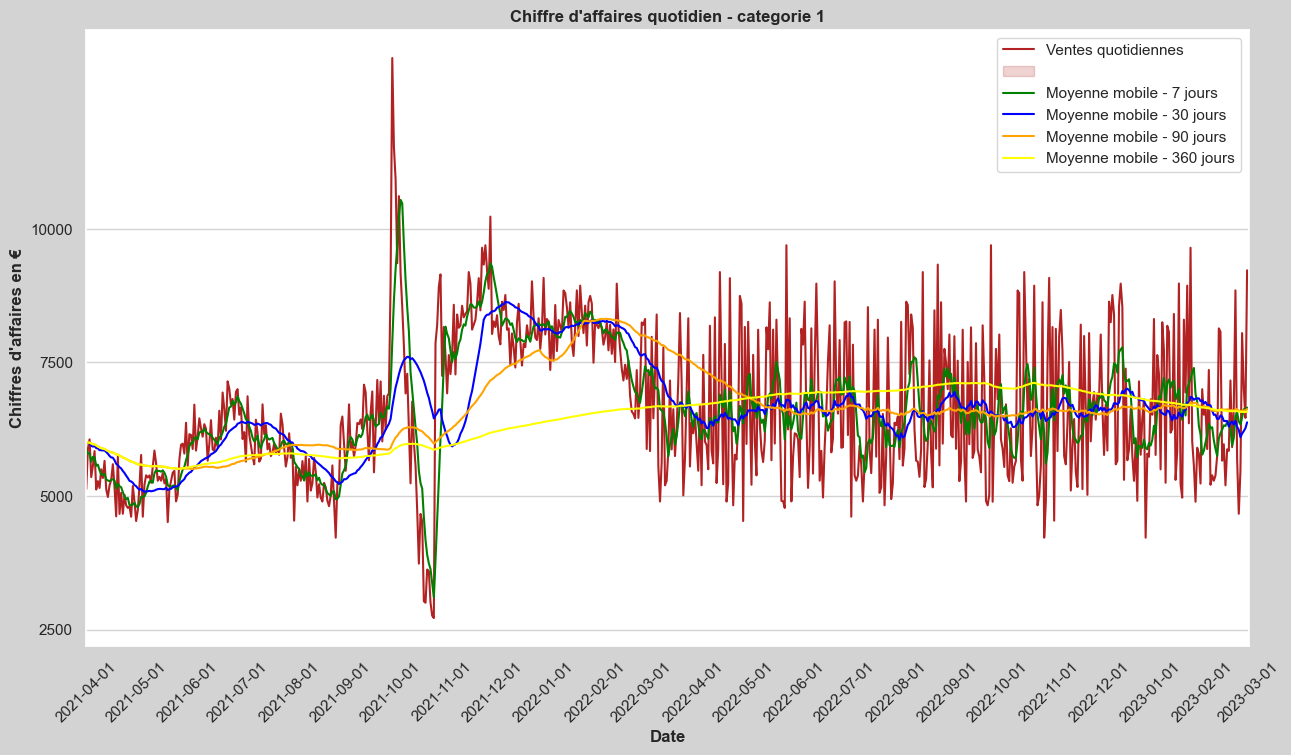

In [68]:
# graphique moyennes mobiles sur la categ 1 :
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph14 = sns.lineplot(data=ca_jour_categ1, x='date', y='price', color="firebrick")
graph14.set_title("Chiffre d'affaires quotidien - categorie 1",fontweight = 'bold')
plt.xlabel('Date',fontweight = 'bold')
plt.ylabel("Chiffres d'affaires en €",fontweight = 'bold')
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12', '2023-01', '2023-02', '2023-03'], rotation=45)
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.yticks([0,2500,5000,7500,10000])
plt.grid(axis = 'y', color="lightgrey")
plt.plot(ca_jour_categ1['date'],ca_jour_categ1['SMA_weekly'], color = 'green')
plt.plot(ca_jour_categ1['date'],ca_jour_categ1['SMA_monthly'], color = 'blue')
plt.plot(ca_jour_categ1['date'],ca_jour_categ1['SMA_quarterly'], color = 'orange')
plt.plot(ca_jour_categ1['date'],ca_jour_categ1['SMA_yearly'], color = 'yellow')
plt.legend(labels=['Ventes quotidiennes',"",'Moyenne mobile - 7 jours',
                    'Moyenne mobile - 30 jours','Moyenne mobile - 90 jours',
                    'Moyenne mobile - 360 jours'])
plt.savefig("graph14.png", bbox_inches='tight')
plt.show()

##### Catégorie 2 <a class="anchor" id="chap6.4.3"></a>

In [69]:
# Création d'un DF pour la categ 2 et les moyennes mobiles :
ca_jour_categ2 = df_ventes_graph.loc[df_ventes_graph['categ'] == '2'].copy()

ca_jour_categ2['SMA_weekly'] = ca_jour_categ2['price'].rolling(7, min_periods=1).mean()
ca_jour_categ2['SMA_monthly'] = ca_jour_categ2['price'].rolling(30, min_periods=1).mean()
ca_jour_categ2['SMA_quarterly'] = ca_jour_categ2['price'].rolling(90, min_periods=1).mean()
ca_jour_categ2['SMA_yearly'] = ca_jour_categ2['price'].rolling(360, min_periods=1).mean()

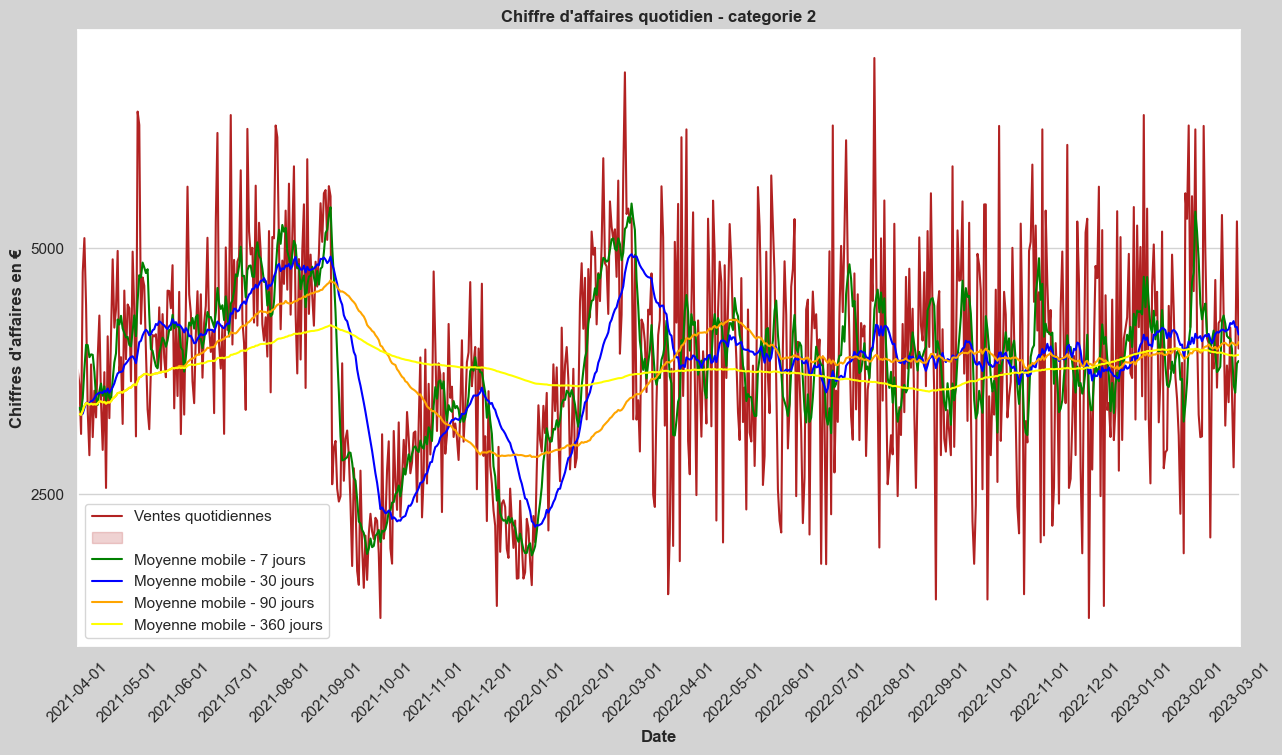

In [70]:
# graphique moyennes mobiles sur la categ 2 :
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph15 = sns.lineplot(data=ca_jour_categ2, x='date', y='price', color="firebrick")
graph15.set_title("Chiffre d'affaires quotidien - categorie 2",fontweight = 'bold')
plt.xlabel('Date',fontweight = 'bold')
plt.ylabel("Chiffres d'affaires en €",fontweight = 'bold')
plt.xticks(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
            '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
            '2022-11', '2022-12', '2023-01', '2023-02', '2023-03'], rotation=45)
plt.xlim([dt.date(2021, 4, 1), dt.date(2023, 3, 1)])
plt.yticks([0,2500,5000,7500,10000])
plt.grid(axis = 'y', color="lightgrey")
plt.plot(ca_jour_categ2['date'],ca_jour_categ2['SMA_weekly'], color = 'green')
plt.plot(ca_jour_categ2['date'],ca_jour_categ2['SMA_monthly'], color = 'blue')
plt.plot(ca_jour_categ2['date'],ca_jour_categ2['SMA_quarterly'], color = 'orange')
plt.plot(ca_jour_categ2['date'],ca_jour_categ2['SMA_yearly'], color = 'yellow')
plt.legend(labels=['Ventes quotidiennes',"",'Moyenne mobile - 7 jours',
                    'Moyenne mobile - 30 jours','Moyenne mobile - 90 jours',
                    'Moyenne mobile - 360 jours'])
plt.savefig("graph15.png", bbox_inches='tight')

### 6.5 - Autres chiffres clés<a class="anchor" id="chap6.5"></a>

##### Courbe de Lorenz sur la répartition du CA entre les produits :<a class="anchor" id="chap6.5.1"></a>

In [71]:
#Création DF pour analyses : 
df_analyse = df_ventes.groupby(['id_prod', 'categ']).agg({'price' : ['sum'], 
                                                          'session_id' : ['count']})
df_analyse.reset_index(inplace=True)
df_analyse_lorenz = df_analyse[['id_prod', 'price']].copy()

#Calcul du CA total pour Lorenz
ca_tot_lorenz = df_analyse_lorenz['price'].sum()

#Calcul du nombre de produits uniques : 
nb_prod_lorenz = len(df_analyse_lorenz['id_prod'].unique())

In [72]:
df_analyse

,id_prod,categ,price,session_id
,,,sum,count
0,0_0,0,4657.50,1242
1,0_1,0,5352.13,487
2,0_10,0,394.90,22
3,0_100,0,61.80,3
4,0_1000,0,2954.88,432
...,...,...,...,...
3260,2_95,2,395.96,4
3261,2_96,2,28650.18,598
3262,2_97,2,2092.87,13


In [73]:
# Données pour la courbe de Lorenz
df_analyse_lorenz.sort_values(("price", "sum"), inplace=True, ascending=True)
df_analyse_lorenz['ca_total_cum'] = np.cumsum(df_analyse_lorenz['price'])
df_analyse_lorenz['lorenz_value'] = df_analyse_lorenz['ca_total_cum'] / ca_tot_lorenz[0]
df_analyse_lorenz['product_count'] = np.arange(df_analyse_lorenz.shape[0])+1
df_analyse_lorenz['product_base_1'] = df_analyse_lorenz['product_count']/nb_prod_lorenz

In [74]:
df_analyse_lorenz

,id_prod,price,ca_total_cum,lorenz_value,product_count,product_base_1
,,sum,,,,
595,0_1539,0.99,0.99,8.231025e-08,1,0.000306
313,0_1284,1.38,2.37,1.970458e-07,2,0.000613
719,0_1653,1.98,4.35,3.616663e-07,3,0.000919
1784,0_541,1.99,6.34,5.271182e-07,4,0.001225
665,0_1601,1.99,8.33,6.925701e-07,5,0.001531
...,...,...,...,...,...,...
3152,2_209,56971.86,11737290.11,9.758579e-01,3261,0.998775
3034,2_102,60736.78,11798026.89,9.809077e-01,3262,0.999081
3045,2_112,65407.76,11863434.65,9.863458e-01,3263,0.999387


In [75]:
# Création des données pour les lignes des 20% et 80%
# 80% du CA :
df_analyse_lorenz80 = df_analyse_lorenz.iloc[(df_analyse_lorenz['lorenz_value']-0.8).abs().argsort()[:1]]

#Valeur :
lorenz80 = df_analyse_lorenz80['lorenz_value'].tolist()[0]

#Index : 
index80 = df_analyse_lorenz80.index.tolist()[0]

# % produits correspondants a 80% du CA cumulé :
product80 = df_analyse_lorenz.loc[index80, 'product_base_1'].values[0]

# 20% du CA cumule
df_analyse_lorenz20 = df_analyse_lorenz.iloc[(df_analyse_lorenz['lorenz_value']-0.2).abs().argsort()[:1]]

#Valeur: 
lorenz20 = df_analyse_lorenz20['lorenz_value'].tolist()[0]

#Index :
index20 = df_analyse_lorenz20.index.tolist()[0]

# % produits correspondants à 20% du CA cumulé:
product20 = df_analyse_lorenz.loc[index20, 'product_base_1'].values[0]
print('lorenz80 = ', lorenz80, '\nindex80 = ', index80, '\nproduct80 = ', product80, '\nlorenz20 = ',
      lorenz20, '\nindex20 = ', index20, '\nproduct20 = ', product20)


# Données pour les 50% : 
# 50% du CA cumulé
df_analyse_lorenz50 = df_analyse_lorenz.iloc[(df_analyse_lorenz['lorenz_value']-0.5).abs().argsort()[:1]]

# for values
lorenz50 = df_analyse_lorenz50['lorenz_value'].tolist()[0]

# for index
index50 = df_analyse_lorenz50.index.tolist()[0]

# % produits correspondants à 50% du CA cumulé :
product50 = df_analyse_lorenz.loc[index50, 'product_base_1'].values[0]

print("Chiffre d'affaires medial atteint avec", round(product50*100, 2), "% des produits.")

lorenz80 =  0.8002715273925484 
index80 =  2491 
product80 =  0.9834609494640123 
lorenz20 =  0.20001748469326555 
index20 =  198 
product20 =  0.7859111791730474
Chiffre d'affaires medial atteint avec 92.96 % des produits.


In [76]:
#Calcul de l'aire sous la courbe de Lorenz
aire3 = df_analyse_lorenz['lorenz_value'].sum() / nb_prod_lorenz

#Calcul du coefficient de Gini : 
S3 = (0.5 - aire3)
gini3 = S3 * 2
print('Coefficient de Gini:',round(gini3,4))

Coefficient de Gini: 0.7437


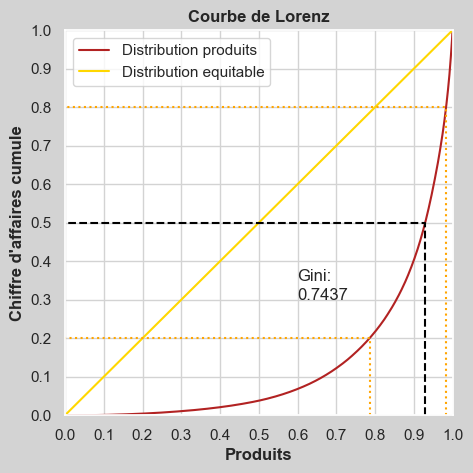

In [77]:
#Graphique courbe de Lorenz : 
sns.set(rc={'figure.figsize':(5,5),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph16 = sns.lineplot(data=df_analyse_lorenz, x='product_base_1', y='lorenz_value', 
                       color="firebrick", label='Distribution produits')
graph16.set_title("Courbe de Lorenz", fontweight = 'bold')
plt.xlabel('Produits', fontweight = 'bold')
plt.ylabel("Chiffre d'affaires cumule", fontweight = 'bold')
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], rotation=0)
plt.xlim([0, 1])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.ylim([0, 1])
plt.grid(axis='both', color='lightgrey')
plt.savefig("graph16.png", bbox_inches='tight')

#Ajouts au graphique : 
plt.text(0.60, 0.35, 'Gini:')
plt.text(0.60, 0.30, round(gini3,4))

#Distribution équitable : 
origin3 = [0, 0]
limit3 = [1, 1]
x_values = [origin3[0], limit3[0]]
y_values = [origin3[1], limit3[1]]
plt.plot(x_values, y_values, 'gold', label='Distribution equitable')
plt.legend(loc="upper left")

# Lignes de lecture des 20%-80% : 
x_20 = [product20, product20, 0]
y_20 = [0, lorenz20, lorenz20]
plt.plot(x_20, y_20, linestyle='dotted', color='orange')
x_80 = [product80, product80, 0]
y_80 = [0, lorenz80, lorenz80]
plt.plot(x_80, y_80, linestyle='dotted', color='orange')

#Ligne de lecture des 50% : 
x_50 = [product50, product50, 0]
y_50 = [0, lorenz50, lorenz50]
plt.plot(x_50, y_50, linestyle='dashed', color='black')

plt.savefig("graph16.png", bbox_inches='tight')

Un indice de Gini très éloigné de 0, le prix des produits est très disparate, donc pas de répartition égale entre les produits. <br> 
La lecture du graphique permet de voir entre autre, que 20% des produits cumulent à eux seuls près de 80% du CA, qu'il faut moins de 10% des produits pour atteindre les 50% du CA et que 80% du chiffre d'affaire est cumulé sur moins de 5% des produits.

##### Recherche des meilleurs clients : <a class="anchor" id="chap6.5.2"></a>

In [78]:
# Meilleurs clients:
best_client = df_ventes.groupby(["client_id"])["price"].sum()

print("Clients ayant le plus dépensé")
print(best_client.nlargest(10))

Clients ayant le plus dépensé
client_id
c_1609    326039.89
c_4958    290227.03
c_6714    153918.60
c_3454    114110.57
c_1570      5285.82
c_3263      5276.87
c_2140      5260.18
c_2899      5214.05
c_7319      5155.77
c_7959      5135.75
Name: price, dtype: float64


4 clients sortent clairement du lot. Se sont sans doute des clients professionnels type revendeurs ou bibliothécaires. Je choisis de les conserver en les considérant comme clients uniques. Mais il peut être intéressant de les mettre de côté suivant les cas d'études.

##### Achat et montant moyen par client :<a class="anchor" id="chap6.5.3"></a>

In [79]:
# Nombre d'achats et montant moyen par client:
nbr_achats_moy = df_complet.groupby(["client_id"])["session_id"].count().mean()
montant_achats_moy = df_ventes.groupby(["client_id"])["price"].sum().mean()

print("Le nombre moyen d'achat par client depuis l'ouverture de notre site est", round(nbr_achats_moy,2))
print("Le montant moyen d'achat par client depuis l'ouverture de notre site est", round(montant_achats_moy,2))

Le nombre moyen d'achat par client depuis l'ouverture de notre site est 79.75
Le montant moyen d'achat par client depuis l'ouverture de notre site est 1398.57


##### Courbe de Lorenz sur la répartition du CA entre les clients :<a class="anchor" id="chap6.5.4"></a>

In [80]:
#Création DF pour analyses : 
df_analyse2 = df_ventes.groupby(['client_id']).agg({'price' : ['sum'], 
                                                          'session_id' : ['count']})
df_analyse2.reset_index(inplace=True)
df_analyse_lorenz2 = df_analyse2[['client_id', 'price']].copy()

#Calcul du CA total pour Lorenz2
ca_tot_lorenz2 = df_analyse_lorenz2['price'].sum()

#Calcul du nombre de produits uniques : 
nb_client_lorenz2 = len(df_analyse_lorenz2['client_id'].unique())
nb_cli = len(df_analyse_lorenz2['client_id'].unique())
nb_cli

8600

In [81]:
# Création d'un DF pour la seconde courbe de Lorenz : 
df_analyse_lorenz2.sort_values(("price", "sum"), inplace=True, ascending=True)
df_analyse_lorenz2['amount_spent_cum'] = np.cumsum(df_analyse_lorenz2['price'])
df_analyse_lorenz2['lorenz_value'] = df_analyse_lorenz2['amount_spent_cum'] / ca_tot_lorenz2[0]
df_analyse_lorenz2['client_count'] = np.arange(df_analyse_lorenz2.shape[0])+1
df_analyse_lorenz2['client_base_1'] = df_analyse_lorenz2['client_count']/nb_cli
df_analyse_lorenz2.tail()

,client_id,price,amount_spent_cum,lorenz_value,client_count,client_base_1
,,sum,,,,
634,c_1570,5285.82,11143367.01,0.926478,8596,0.999535
2724,c_3454,114110.57,11257477.58,0.935965,8597,0.999651
6337,c_6714,153918.60,11411396.18,0.948763,8598,0.999767
4388,c_4958,290227.03,11701623.21,0.972892,8599,0.999884
677,c_1609,326039.89,12027663.10,1.000000,8600,1.000000


In [82]:
#Données pour la création de la ligne des 20%-80% : 
# 80% du CA cumulé
df_analyse_lorenz2_80 = df_analyse_lorenz2.iloc[(df_analyse_lorenz2['lorenz_value']-0.8).abs().argsort()[:1]]

#Valeurs
lorenz80_2 = df_analyse_lorenz2_80['lorenz_value'].tolist()[0]

#Index
index80_2 = df_analyse_lorenz2_80.index.tolist()[0]

# % produits correspondants a 80% du CA cumulé :
product80_2 = df_analyse_lorenz2.loc[index80_2, 'client_base_1'].values[0]

# 20% du CA cumulé
df_analyse_lorenz2_20 = df_analyse_lorenz2.iloc[(df_analyse_lorenz2['lorenz_value']-0.2).abs().argsort()[:1]]

#Valeurs
lorenz20_2 = df_analyse_lorenz2_20['lorenz_value'].tolist()[0]

#Index
index20_2 = df_analyse_lorenz2_20.index.tolist()[0]

# % produits correspondants a 20% du CA cumulé
product20_2 = df_analyse_lorenz2.loc[index20_2, 'client_base_1'].values[0]

print('lorenz80 = ', lorenz80_2, '\nindex80 = ', index80_2, '\nproduct80 = ', product80_2, '\nlorenz20 = ',
      lorenz20_2, '\nindex20 = ', index20_2, '\nproduct20 = ', product20_2)


# Ligne des 50% : 
# 50% du CA cumulé
df_analyse_lorenz2_50 = df_analyse_lorenz2.iloc[(df_analyse_lorenz2['lorenz_value']-0.5).abs().argsort()[:1]]

#Valeur :
lorenz50_2 = df_analyse_lorenz2_50['lorenz_value'].tolist()[0]

#Index
index50_2 = df_analyse_lorenz2_50.index.tolist()[0]

# % produits correspondants a 50% du CA cumulé
product50_2 = df_analyse_lorenz2.loc[index50_2, 'client_base_1'].values[0]

print("Chiffre d'affaires medial atteint avec", round(product50_2*100, 2), "% des clients.")

lorenz80 =  0.8001080766886461 
index80 =  7704 
product80 =  0.9544186046511628 
lorenz20 =  0.20002227781055795 
index20 =  8496 
product20 =  0.4966279069767442
Chiffre d'affaires medial atteint avec 78.7 % des clients.


In [83]:
#Aire sous la courbe de Lorenz :
aire2 = df_analyse_lorenz2['lorenz_value'].sum() / nb_cli

# calculate Gini coefficient
S2 = (0.5 - aire2)
gini2 = S2 * 2
print('Coefficient de Gini:' , round(gini2,4))

Coefficient de Gini: 0.4418


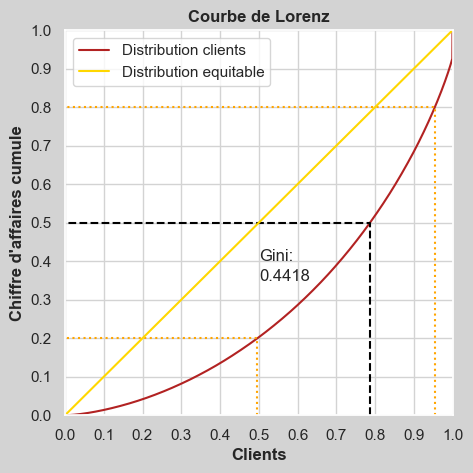

In [84]:
#Graphique courbe de Lorenz :
sns.set(rc={'figure.figsize':(5, 5),'axes.facecolor':'white', 'figure.facecolor':'lightgray'})
graph17 = sns.lineplot(data=df_analyse_lorenz2, x='client_base_1', y='lorenz_value', color="firebrick", label='Distribution clients')
graph17.set_title("Courbe de Lorenz", fontname='Arial', fontweight='bold')
plt.xlabel('Clients', fontweight='bold')
plt.ylabel("Chiffre d'affaires cumule", fontweight='bold')
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], rotation=0)
plt.xlim([0,1])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.ylim([0, 1])
plt.grid(axis='both', color='lightgrey')

#Ajouts dans le graphique : 
plt.text(0.50, 0.40, 'Gini:')
plt.text(0.50, 0.35, round(gini2,4))

#Lignes de lecture des 20% et 80% :
x_20_2 = [product20_2, product20_2, 0]
y_20_2 = [0, lorenz20_2, lorenz20_2]
plt.plot(x_20_2, y_20_2, linestyle='dotted', color='orange')
x_80_2 = [product80_2, product80_2, 0]
y_80_2 = [0, lorenz80_2, lorenz80_2]
plt.plot(x_80_2, y_80_2, linestyle='dotted', color='orange')

#Lignes de lecture des 50% : 
x_50_2 = [product50_2, product50_2, 0]
y_50_2 = [0, lorenz50_2, lorenz50_2]
plt.plot(x_50_2, y_50_2, linestyle='dashed', color='black')

#Distribution équitable :
origin = [0, 0]
limit = [1, 1]
x_values = [origin[0], limit[0]]
y_values = [origin[1], limit[1]]
plt.plot(x_values, y_values, 'gold', label='Distribution equitable')
plt.legend(loc="upper left")

plt.savefig("graph17.png", bbox_inches='tight')

Indice de Gini éloigné de 0 : les clients ont des montants d'achats très différents. Si on ne les avait pas identifié, le graphique aurait permis la mise en avant de nos 4 clients stars.<br>
A peu près 20% des clients font à eux seuls 50% du CA.

##### Nombre moyen d'achats par sessions:<a class="anchor" id="chap6.5.5"></a>

In [85]:
print("Il y a eu",
      df_complet["session_id"].nunique(),
      "sessions")

print("Une session aboutie en moyenne à",
      round(df_complet.groupby(["session_id","client_id"])["id_prod"].count().mean(),2),
      "achats")

Il y a eu 345505 sessions
Une session aboutie en moyenne à 1.99 achats


##### Répartition du genre parmis les clients:<a class="anchor" id="chap6.5.6"></a>

In [86]:
# create data for pie by genre
genre_pie = customers.groupby(['sex'])['client_id'].count().reset_index()

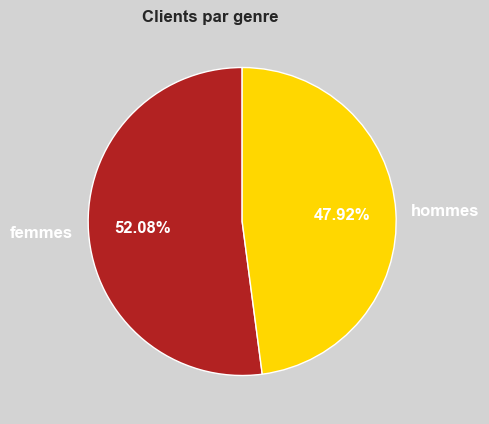

In [87]:
#Graphique pour la répartition du genre :

fig, ax = plt.subplots(figsize=(5,5))
fig.set_facecolor('lightgrey')

colors_graph18 = ['firebrick','gold']

ax.pie(genre_pie['client_id'], radius=1,
       colors=colors_graph18, labels=['femmes','hommes'],
       autopct='%1.2f%%', pctdistance=0.65, textprops={'fontsize': 12, 
                'color':'white','fontweight':'bold'}, startangle=90)

plt.text(-0.65, 1.3, "Clients par genre", fontweight='bold')

plt.savefig("graph18.png", bbox_inches='tight')

##### Dépenses par genres :<a class="anchor" id="chap6.5.7"></a>

montant total des achats par genre:
 sex
f    5950843.68
m    6076819.42
Name: price, dtype: float64
nombre total d'achats par genre:
 sex
f    342693
m    344841
Name: price, dtype: int64
montant moyen des achats par genre:
 sex
f    17.364941
m    17.622091
Name: price, dtype: float64


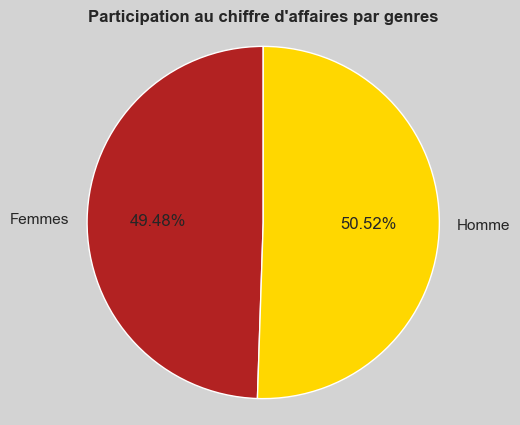

In [88]:
repartition_achats_genre = df_ventes.groupby(["sex"])["price"].sum()
print("montant total des achats par genre:\n", repartition_achats_genre)

nbr_achats_genre = df_ventes.groupby(["sex"])["price"].count()
print("nombre total d'achats par genre:\n", nbr_achats_genre)

moy_achats_genre = df_ventes.groupby(["sex"])["price"].mean()
print("montant moyen des achats par genre:\n", moy_achats_genre)


# Graphique:
graph19, ax3 = plt.subplots()
ax3.pie(repartition_achats_genre, colors=colors_graph18,
        labels=["Femmes","Homme"],
        autopct="%1.2f%%", startangle=90)
ax3.axis("equal")
plt.title("Participation au chiffre d'affaires par genres", fontweight='bold')
plt.savefig("graph19.png", bbox_inches='tight')

##### Répartition des âges parmis les clients :<a class="anchor" id="chap6.5.8"></a>

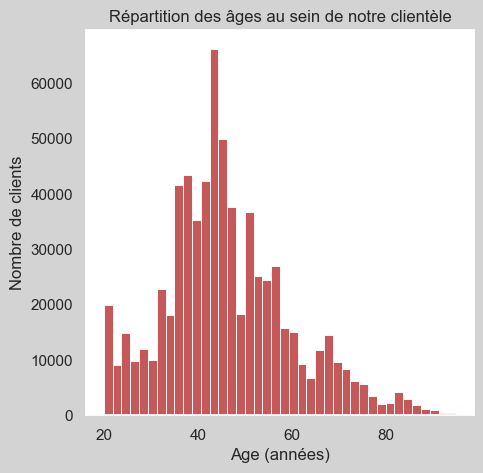

In [89]:
# Repartition des ages parmis nos clients:
Graph20 = sns.histplot(data=df_complet["age"],
             bins=40, color="firebrick")
plt.title("Répartition des âges au sein de notre clientèle")
plt.ylabel("Nombre de clients")
plt.xlabel("Age (années)")
plt.savefig("graph20.png", bbox_inches='tight')

In [90]:
# Test de Normalite de la repartition des ages:
print(st.anderson(customers["age"], dist="norm"))

AndersonResult(statistic=54.304839298933075, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=45.724393921818816, scale=16.917958031023534)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


On utilise le test d'Anderson car il est non paramétrique et utilisé pour les grands échantillons. H0 = les données suivent une distribution normale alpha 1% statistique du test d'Anderson (54) > valeure critique (1) On rejette H0. On considère que l'âge ne suit pas une distribution normale avec un risque d'erreure 1%

In [91]:
#Répartition des tranches d'age : 
customers.loc[(customers['age'] >= 7) & (customers['age'] <= 14), 'age_range'] = "7-14"
customers.loc[(customers['age'] >= 15) & (customers['age'] <= 24), 'age_range'] = "15-24"
customers.loc[(customers['age'] >= 25) & (customers['age'] <= 34), 'age_range'] = "25-34"
customers.loc[(customers['age'] >= 35) & (customers['age'] <= 49), 'age_range'] = "35-49"
customers.loc[(customers['age'] >= 50) & (customers['age'] <= 64), 'age_range'] = "50-64"
customers.loc[(customers['age'] >= 65), 'age_range'] = "65+"

# Ajout des tranches d'ages:
df_ventes["age_range"] = pd.cut(x= df_ventes["age"], bins=[7,15,25,35,50,65,100], include_lowest=False, ordered=True)

# Repartition des achats par tranches d'ages:
repartition_achats_age_range = df_ventes.groupby(["age_range"])["price"].sum()
print("montant total des achats par tranches d'age:\n", repartition_achats_age_range)

# Nombre d'achats par tranches d'ages:
nbr_achats_age_range = df_ventes.groupby(["age_range"])["price"].count()
print("nombre total d'achats par tranches d'age:\n",nbr_achats_age_range)

# Motant moyen des achats par tranches d'ages:
moy_achats_age_range = df_ventes.groupby(["age_range"])["price"].mean()
print("montant moyen des achats par tranches d'age:\n", moy_achats_age_range)

montant total des achats par tranches d'age:
 age_range
(7, 15]            0.00
(15, 25]     1825114.03
(25, 35]     2198103.03
(35, 50]     4483770.02
(50, 65]     2349884.60
(65, 100]    1170791.42
Name: price, dtype: float64
nombre total d'achats par tranches d'age:
 age_range
(7, 15]           0
(15, 25]      43995
(25, 35]      89300
(35, 50]     338228
(50, 65]     146325
(65, 100]     69686
Name: price, dtype: int64
montant moyen des achats par tranches d'age:
 age_range
(7, 15]            NaN
(15, 25]     41.484578
(25, 35]     24.614816
(35, 50]     13.256649
(50, 65]     16.059351
(65, 100]    16.800956
Name: price, dtype: float64


## 7 - Corrélations :<a class="anchor" id="chap7"></a>

### 7.1 - Entre le genre et la catégorie d'achat :<a class="anchor" id="chap7.1"></a>

In [92]:
# Table de contingence pour Chi²:
categ_sex = pd.crosstab(df_ventes["sex"],df_ventes["categ"])
print(categ_sex)

# Chi²:
cs_chi2, cs_p, cs_dof, cs_exp = st.chi2_contingency(categ_sex)

print("Les fréquences théoriques sont:\n", cs_exp,3)
print(f"Ce qui donne un X² de {cs_chi2:.3f} à", cs_dof, "ddl")
print(f"soit une p-value de", cs_p)

# Calcul V de Cramer:
n_cs = len(df_ventes)
minDim_cs = min(categ_sex.shape)-1

V_cs = np.sqrt((cs_chi2/n_cs) / minDim_cs)

print("Le V de Cramer vaux:", V_cs)

categ       0       1      2
sex                         
f      206103  119307  17283
m      209356  116285  19200
Les fréquences théoriques sont:
 [[207080.50959953 117427.98066132  18184.50973915]
 [208378.49040047 118164.01933868  18298.49026085]] 3
Ce qui donne un X² de 158.254 à 2 ddl
soit une p-value de 4.3205822283997063e-35
Le V de Cramer vaux: 0.015171569112675852


L'hypothèse n0 est ici l'indépendance des variables catégories achetées et genre. Dans tous les cas que l'on prenne un seuil à 5% (0,05) ou 1% (0,01), la p-value sera ici toujours très inférieure au seuil significatif, l'hypothèse nulle est rejetée, les catégories des livres achetées dépendent donc du genre de l'acheteur.

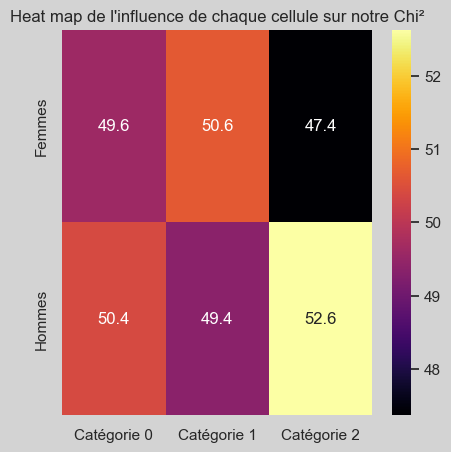

In [93]:
# Heat map pour identifier les cellules les plus influantes sur le Chi²:
len_i = categ_sex.shape[0]
len_j = categ_sex.shape[1]
xij = np.zeros((len_i, len_j))
for i in range(len_i):
    for j in range(len_j):
        xij[i,j] = (categ_sex.values[i,j] / categ_sex.values[:,j].sum())*100
        
sns.set(rc={'figure.figsize':(5,5),'axes.facecolor':'white', 'figure.facecolor':'lightgray'})
graph21 = sns.heatmap(xij,
            annot=xij,
            fmt = ".1f", cmap='inferno',
            yticklabels=["Femmes","Hommes"],
            xticklabels=["Catégorie 0", "Catégorie 1", "Catégorie 2"])
plt.title("Heat map de l'influence de chaque cellule sur notre Chi²")
plt.plot()
plt.savefig("graph21.png", bbox_inches='tight')

### 7.2 - Entre l'âge et le montant de l'achat :<a class="anchor" id="chap7.2"></a>

In [94]:
# Lien entre l'age et le montant des achats:
age = df_ventes.groupby(["age"])["client_id"].count()
tot_achats_age = df_ventes.groupby(["age"])["price"].sum()

model = ols('age ~ tot_achats_age', data=tot_achats_age).fit()
anova = sm.stats.anova_lm(model, typ=2)
anova

,sum_sq,df,F,PR(>F)
tot_achats_age,3.989246e+09,1.0,167.834304,1.033003e-20
Residual,1.758903e+09,74.0,NaN,NaN


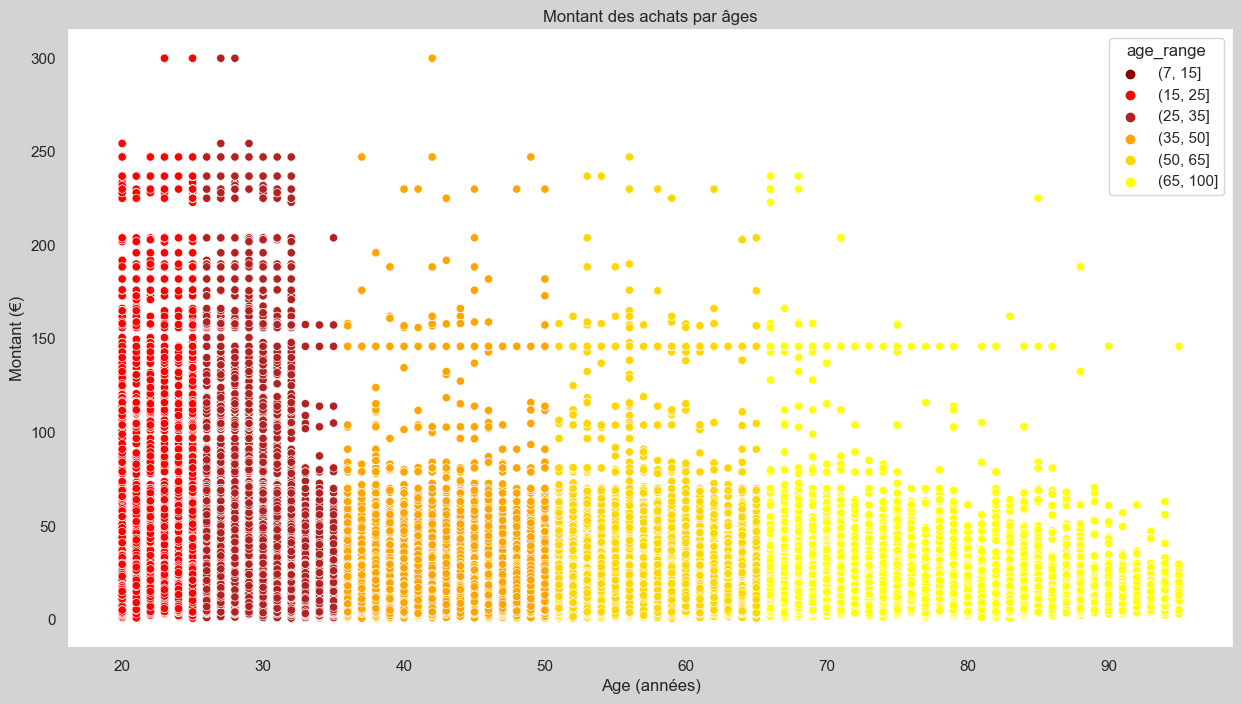

In [95]:
# Graphique:
sns.set(rc={'figure.figsize':(15,8),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph22 = sns.scatterplot(x= df_ventes["age"], y=df_ventes["price"], hue=df_ventes["age_range"],
               palette=['darkred','red','firebrick','orange', 'gold','yellow'])
plt.ylabel("Montant (€)")
plt.xlabel("Age (années)")
plt.title("Montant des achats par âges")
plt.savefig("graph22.png", bbox_inches='tight')

### 7.3 - Entre l'âge et les catégories :<a class="anchor" id="chap7.3"></a>

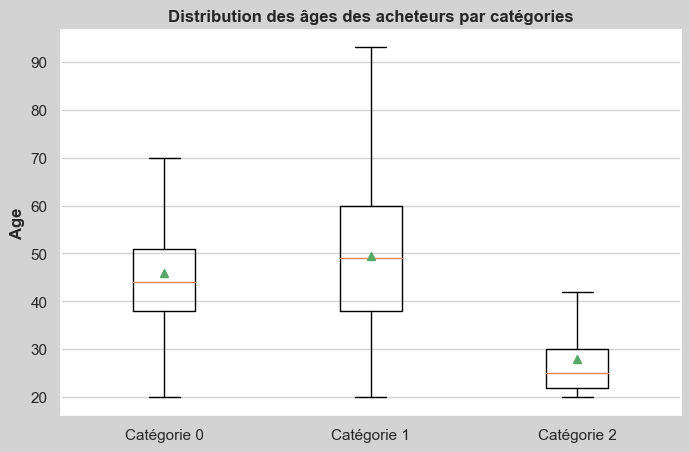

In [96]:
# Categories les plus achetees par age:
categ = df_ventes["categ"].unique()
categ_age = {categ: df_ventes.loc[df_ventes["categ"]==categ, "age"] for categ in categ}

# Graphique:
sns.set(rc={'figure.figsize':(8,5),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph23 = plt.boxplot([
    categ_age["0"],
    categ_age["1"],
    categ_age["2"]]
    ,labels=["Catégorie 0", "Catégorie 1", "Catégorie 2"],showmeans=True, 
    showfliers=False)
plt.ylabel("Age", fontweight="bold")
plt.title("Distribution des âges des acheteurs par catégories", fontweight="bold")
plt.grid(axis='y', color='lightgrey')
plt.savefig("graph23.png", bbox_inches='tight')

In [97]:
# Lien entre age et categorie achetees:
print(type(categ_age["0"].values))
print(st.kruskal(categ_age["0"], categ_age["1"], categ_age["2"]))

<class 'numpy.ndarray'>
KruskalResult(statistic=78458.43837285662, pvalue=0.0)


Le test de Kruskal Wallis, est non paramétrique, les groupes doivent contenir plus de cinq individus. p-val < 0,01 on rejette l'hypothèse nulle selon laquelle il n'y aurait pas de différence entre l'âge median d'achat par catégorie. Kruskal est un test de rang.

### 7.4 - Entre l'âge et la fréquence d'achat :<a class="anchor" id="chap7.4"></a>

In [98]:
# Frequence d'achat mensuelle:
freq_mensu= df_ventes.groupby(["client_id", "year", "month"])["session_id"].nunique().groupby(["client_id"]).mean().reset_index()

# Ajout des ages au df frequence mensuelle:
freq_mensu = pd.merge(customers, freq_mensu, on="client_id",how="outer")
freq_mensu = freq_mensu.dropna()                                                
#On enleve les clients non acheteurs

# Lien entre l'age et la frequence d'achat mensuelle:
freq_age = freq_mensu.groupby(["age"])["session_id"].sum()

print(freq_age)

# Ces lignes peuvent être ajoutees ou retirees pour avoir la correlation et le scatterplot en prennant en compte les libraires:
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_1609")].index, inplace=True)
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_3454")].index, inplace=True)
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_4958")].index, inplace=True)
freq_mensu.drop(freq_mensu[(freq_mensu["client_id"] == "c_6714")].index, inplace=True)

# Correlation entre l'age et le montant total des achats
print("Corrélation de Spearman:", st.spearmanr(freq_mensu["age"], freq_mensu["session_id"]))

age
20    635.581867
21    206.075821
22    203.782338
23    182.552951
24    193.675196
         ...    
91     15.140739
92     11.415217
93      6.610458
94      8.447205
95      6.482843
Name: session_id, Length: 76, dtype: float64
Corrélation de Spearman: SignificanceResult(statistic=0.2041035000469351, pvalue=1.6483221326747356e-81)


In [99]:
freq_mensu

,client_id,sex,birth,age,age_range,session_id
0,c_4410,f,1967,57,50-64,2.476190
1,c_7839,f,1975,49,35-49,1.666667
2,c_1699,f,1984,40,35-49,1.000000
3,c_5961,f,1962,62,50-64,2.416667
4,c_5320,m,1943,81,65+,1.384615
...,...,...,...,...,...,...
8616,c_7920,m,1956,68,65+,2.400000
8617,c_7403,f,1970,54,50-64,5.347826
8618,c_5119,m,1974,50,50-64,1.562500
8619,c_5643,f,1968,56,50-64,3.958333


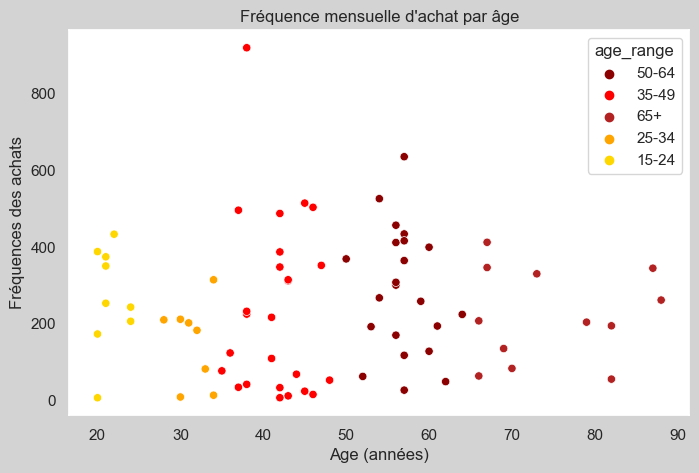

In [100]:
# Graphique
sns.set(rc={'figure.figsize':(8,5),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph24 = sns.scatterplot(x=freq_mensu["age"], y=freq_age, hue=freq_mensu["age_range"],
                         palette=['darkred','red','firebrick','orange', 'gold'])
plt.ylabel("Fréquences des achats")
plt.xlabel("Age (années)")
plt.title("Fréquence mensuelle d'achat par âge")
plt.savefig("graph24.png", bbox_inches='tight')

### 7.4 - Entre l'âge et le panier moyen :<a class="anchor" id="chap7.5"></a>

In [101]:
#Création d'un DF pour l'analyse : 
age_panier_moy=pd.DataFrame(df_ventes.groupby(["age", "age_range", "client_id"])['price'].mean())


In [102]:
age_panier_moy.reset_index(inplace=True)
age_panier_moy.dropna(inplace=True)

In [103]:
age_panier_moy

,age,age_range,client_id,price
8649,20.0,"(15, 25]",c_1042,29.062500
8653,20.0,"(15, 25]",c_1046,22.428780
8674,20.0,"(15, 25]",c_1065,41.654074
8699,20.0,"(15, 25]",c_1088,45.420769
8701,20.0,"(15, 25]",c_109,59.312857
...,...,...,...,...
3865478,94.0,"(65, 100]",c_4679,10.990000
3868310,94.0,"(65, 100]",c_7232,17.873614
3917770,95.0,"(65, 100]",c_5302,15.184474
3918288,95.0,"(65, 100]",c_577,15.912696


In [104]:
#Test statistique de 2 variables quantitatives : Spearman
# Correlation entre l'age et le panier moyen des achats : 
print("Corrélation de Spearman:", st.spearmanr(age_panier_moy["age"], age_panier_moy["price"]))

Corrélation de Spearman: SignificanceResult(statistic=-0.3258367711846324, pvalue=7.36322508409488e-212)


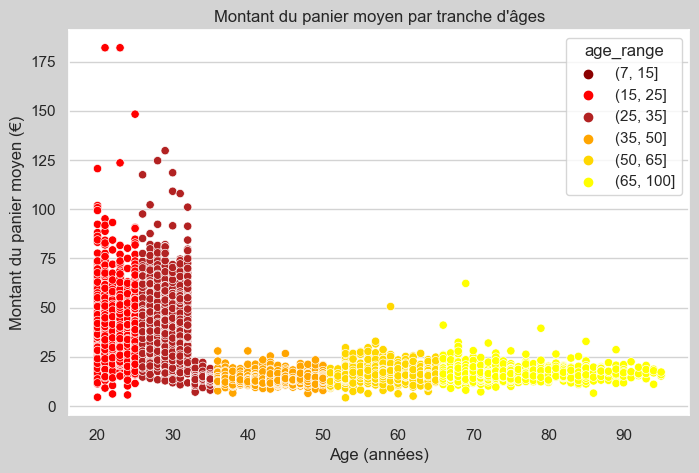

In [105]:
# Graphique:
sns.set(rc={'figure.figsize':(8,5),'axes.facecolor':'white', 'figure.facecolor':'lightgrey'})
graph25 = sns.scatterplot(x=age_panier_moy["age"], y=age_panier_moy["price"], 
                         hue=age_panier_moy['age_range'], palette=['darkred','red','firebrick','orange', 'gold', 'yellow'])
plt.ylabel("Montant du panier moyen (€)")
plt.xlabel("Age (années)")
plt.grid(axis="y", color="lightgray")
plt.title("Montant du panier moyen par tranche d'âges")
plt.savefig("graph25.png", bbox_inches='tight')